In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

In [43]:
from timeit import default_timer as timer



from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [44]:

select_station = 'ATTO'

In [45]:
xr.set_options(keep_attrs=True) 

In [46]:
calc_seasons = ['ALL_year']

In [47]:
tau_lims = [5,50]
r_eff_lim = 1
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

In [48]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'



## Daytime values


Set the daytime to be from 10 to 17 each day

In [49]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [50]:
models = ['ECHAM-SALSA','NorESM']
mod2cases = {'ECHAM-SALSA':['SALSA_BSOA_feedback'],
             'NorESM':['OsloAero_intBVOC_f09_f09_mg17_fssp']
            }
di_mod2cases = mod2cases.copy()

In [51]:
dic_df_station=dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv


## NorESM settings

In [52]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-2


temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

In [53]:
case_name = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'
case_name_noresm = 'OsloAero_intBVOC_f09_f09_mg17_fssp245'

case_name1 = 'OsloAero_intBVOC_f09_f09_mg17_full'
case_name2 = 'OsloAero_intBVOC_f09_f09_mg17_ssp245'

In [54]:
cases = [case_name]

## ECHAM-SALSA

### Names etc

In [55]:

case_name = 'SALSA_BSOA_feedback'
case_name_echam = 'SALSA_BSOA_feedback'
time_res = 'hour'
space_res='locations'
model_name='ECHAM-SALSA'
model_name_echam  ='ECHAM-SALSA'

### Input path:

In [56]:
input_path_echam = path_extract_latlon_outdata / model_name_echam / case_name_echam 

In [57]:

cases_echam = [case_name_echam]

### Station variables  and others

In [58]:
varl_st_echam = [
    'mmrtrN500',
    'mmrtrN250',
    'mmrtrN200',
    'mmrtrN100',
    'mmrtrN50',
    'mmrtrN3',
    'SO2_gas',
    'APIN_gas',
    'TBETAOCI_gas',
    'BPIN_gas',
    'LIMON_gas',
    'SABIN_gas',
    'MYRC_gas',
    'CARENE3_gas',
    'ISOP_gas',
    'VBS0_gas',
    'V*BS1_gas',
    'VBS10_gas',
    'ORG_mass',
    'oh_con',
    'tempair',
    'ccn02',
    'ccn10',
]


varl_cl_echam = [
    'airdens',
    'uw',
    'vw',
    'cod',
    'cwp',
    'ceff',
    'ceff_ct',
    #'ceff_ct_incl',
    'lcdnc',
    'lcdnc_ct',
    'clfr',
    'cl_time',
    'aot550nm',
    'up_sw',
    'up_sw_cs',
    'up_sw_noa',
    'up_sw_cs_noa',
    'up_lw',
    'up_lw_cs',
    'up_lw_noa',
    'up_lw_cs_noa',
    'emi_monot_bio',
    'emi_isop_bio',
    'tempair',
    'tempair_ct',
    'T_ct',

]

### Define some strings for files

In [59]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

### Filenames: 

In [60]:
fn_final_echam = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_echam_csv = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_wet_season.csv'
fn_final_echam_csv_stem = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'

### Open data

In [61]:
fl_open = []

for v in varl_cl_echam+ varl_st_echam:
    fn = input_path_echam / f'{case_name}_{from_time1}-{to_time2}_{v}_concat_subs_{str_coordlims}.nc'
    #print(fn)
    if fn.exists():
        fl_open.append(fn)
    else:
        print(f'{v} not found')

tempair_ct not found
T_ct not found
mmrtrN500 not found
mmrtrN250 not found
mmrtrN3 not found
SO2_gas not found
APIN_gas not found
TBETAOCI_gas not found
BPIN_gas not found
LIMON_gas not found
SABIN_gas not found
MYRC_gas not found
CARENE3_gas not found
ISOP_gas not found
VBS0_gas not found
V*BS1_gas not found
VBS10_gas not found
oh_con not found


### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [62]:
dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback'].head()

lon   lev station      APIN_gas      BPIN_gas  \
time                                                                     
2011-12-31 20:00:00 -59.0002  46.0    ATTO  2.821519e-10  2.327659e-10   
2011-12-31 21:00:00 -59.0002  46.0    ATTO  3.356697e-10  2.886502e-10   
2011-12-31 22:00:00 -59.0002  46.0    ATTO  3.897681e-10  3.476375e-10   
2011-12-31 23:00:00 -59.0002  46.0    ATTO  4.394250e-10  4.041688e-10   
2012-01-01 00:00:00 -59.0002  46.0    ATTO  4.848434e-10  4.577898e-10   

                      CARENE3_gas      ISOP_gas     LIMON_gas      MYRC_gas  \
time                                                                          
2011-12-31 20:00:00  4.756145e-11  7.542697e-09  9.003484e-11  2.065036e-11   
2011-12-31 21:00:00  5.905082e-11  7.934987e-09  1.117612e-10  2.457096e-11   
2011-12-31 22:00:00  7.112257e-11  8.214004e-09  1.346019e-10  2.852998e-11   
2011-12-31 23:00:00  8.258064e-11  8.321312e-09  1.562942e-10  3.215490e-11   
2012-01-01 00:00:00  9.330557e-11  8.297556e-09  1.766200e-10  3.546157e-11   

                         ORG_mass  ...  VBS0_gas_conc  VBS10_gas_conc  \
time                               ...                                  
2011-12-31 20:00:00  1.110949e-09  ...   7.210706e-05        0.214239   
2011-12-31 21:00:00  1.150816e-09  ...   1.199499e-05        0.215531   
2011-12-31 22:00:00  1.191303e-09  ...   1.847369e-06        0.215602   
2011-12-31 23:00:00  1.240818e-09  ...   3.476910e-07        0.209877   
2012-01-01 00:00:00  1.302471e-09  ...   1.534583e-07        0.198172   

                          OAG        cwp  ceff_um     lcdnc_cm3        T_C  \
time                                                                         
2011-12-31 20:00:00  1.517814  27.057137      0.0  1.743982e-35  26.015625   
2011-12-31 21:00:00  1.565143  35.123394      0.0  6.643672e-35  25.879364   
2011-12-31 22:00:00  1.611699  54.907210      0.0  1.446207e-35  25.777008   
2011-12-31 23:00:00  1.661339  72.171930      0.0 -3.884656e-35  25.605713   
2012-01-01 00:00:00  1.717620  84.733990      0.0  1.332036e-34  25.360443   

                     is_JJA  is_JA  isSummer  
time                                          
2011-12-31 20:00:00   False  False     False  
2011-12-31 21:00:00   False  False     False  
2011-12-31 22:00:00   False  False     False  
2011-12-31 23:00:00   False  False     False  
2012-01-01 00:00:00   False  False     False  

[5 rows x 70 columns]

In [63]:
fl_open = list(set(fl_open))

In [64]:
ds_all = xr.open_mfdataset(fl_open, decode_cf = False)

In [65]:
ds_all

<xarray.Dataset>
Dimensions:        (time: 61368, lev: 47, lat: 3, lon: 8, nhyi: 48, nhym: 47)
Coordinates:
  * lat            (lat) float64 -2.798 -4.663 -6.528
  * lev            (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
  * lon            (lon) float64 294.4 296.2 298.1 300.0 301.9 303.8 305.6 307.5
  * time           (time) float64 730.0 730.1 730.1 ... 3.287e+03 3.287e+03
Dimensions without coordinates: nhyi, nhym
Data variables: (12/33)
    ORG_mass       (time, lev, lat, lon) float32 dask.array<chunksize=(61368, 47, 3, 8), meta=np.ndarray>
    hyai           (nhyi) float64 dask.array<chunksize=(48,), meta=np.ndarray>
    hyam           (nhym) float64 dask.array<chunksize=(47,), meta=np.ndarray>
    hybi           (nhyi) float64 dask.array<chunksize=(48,), meta=np.ndarray>
    hybm           (nhym) float64 dask.array<chunksize=(47,), meta=np.ndarray>
    airdens        (time, lev, lat, lon) float32 dask.array<chunksize=(61368, 47, 3, 8), meta=np.ndarray>
    ...             ...
    up_lw_cs_noa   (time, lat, lon) float32 dask.array<chunksize=(61368, 3, 8), meta=np.ndarray>
    up_lw_noa      (time, lat, lon) float32 dask.array<chunksize=(61368, 3, 8), meta=np.ndarray>
    up_sw          (time, lat, lon) float32 dask.array<chunksize=(61368, 3, 8), meta=np.ndarray>
    up_sw_cs       (time, lat, lon) float32 dask.array<chunksize=(61368, 3, 8), meta=np.ndarray>
    up_sw_cs_noa   (time, lat, lon) float32 dask.array<chunksize=(61368, 3, 8), meta=np.ndarray>
    up_sw_noa      (time, lat, lon) float32 dask.array<chunksize=(61368, 3, 8), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Oct  4 20:05:09 2022: ncrcat /proj/bolinc/users/x_sarbl...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [66]:
ds_all['time'].attrs['units'] = 'days since 2010-01-01 00:00:00'

ds_all['time'].attrs['calendar'] = 'gregorian'

ds_all['time'] = xr.decode_cf(ds_all[['tempair']])['time']

In [67]:
_dm = ds_all.where(ds_all['time.month'].isin([1,2,3]), drop=True).isel(lat=1,lon=1)

In [68]:
_dm['diff'] = _dm['cl_time']-_dm['clfr']

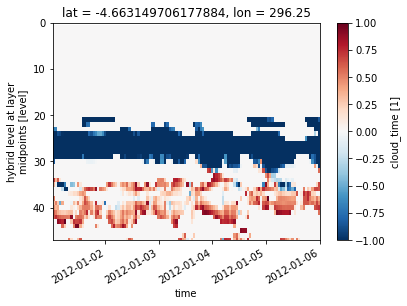

In [69]:
num_days = 5
_dm['diff'].isel(time=slice(0,24*num_days)).plot(x='time', ylim=[47,0])

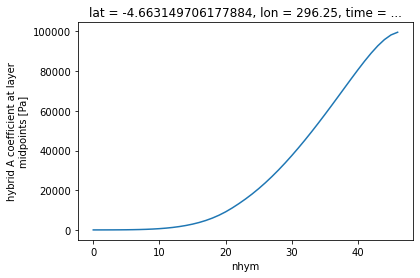

In [70]:
lev = _dm['hyam'].isel(time=0) + _dm['hybm'].isel(time=0)*100000
lev.plot()

In [71]:
lev

<xarray.DataArray (nhym: 47)>
dask.array<add, shape=(47,), dtype=float64, chunksize=(47,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 -4.663
    lon      float64 296.2
    time     datetime64[ns] 2012-01-01T00:52:30
Dimensions without coordinates: nhym
Attributes:
    long_name:  hybrid A coefficient at layer midpoints
    units:      Pa

In [72]:
_dm['pres'] = xr.DataArray(lev.values, dims='lev')

In [73]:
_dm = _dm.swap_dims({'lev':'pres'}).rename({'lev':'lev_orig2','pres':'lev'})
_dm

<xarray.Dataset>
Dimensions:        (lev: 47, time: 15168, nhyi: 48, nhym: 47)
Coordinates:
    lev_orig2      (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
    lat            float64 -4.663
    lon            float64 296.2
  * time           (time) datetime64[ns] 2012-01-01T00:52:30 ... 2018-03-31T2...
  * lev            (lev) float64 0.9946 4.281 11.12 ... 9.826e+04 9.962e+04
Dimensions without coordinates: nhyi, nhym
Data variables: (12/34)
    ORG_mass       (time, lev) float32 dask.array<chunksize=(15168, 47), meta=np.ndarray>
    hyai           (nhyi, time) float64 dask.array<chunksize=(48, 15168), meta=np.ndarray>
    hyam           (nhym, time) float64 dask.array<chunksize=(47, 15168), meta=np.ndarray>
    hybi           (nhyi, time) float64 dask.array<chunksize=(48, 15168), meta=np.ndarray>
    hybm           (nhym, time) float64 dask.array<chunksize=(47, 15168), meta=np.ndarray>
    airdens        (time, lev) float32 dask.array<chunksize=(15168, 47), meta=np.ndarray>
    ...             ...
    up_lw_noa      (time) float32 dask.array<chunksize=(15168,), meta=np.ndarray>
    up_sw          (time) float32 dask.array<chunksize=(15168,), meta=np.ndarray>
    up_sw_cs       (time) float32 dask.array<chunksize=(15168,), meta=np.ndarray>
    up_sw_cs_noa   (time) float32 dask.array<chunksize=(15168,), meta=np.ndarray>
    up_sw_noa      (time) float32 dask.array<chunksize=(15168,), meta=np.ndarray>
    diff           (time, lev) float32 dask.array<chunksize=(15168, 47), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Oct  4 20:05:09 2022: ncrcat /proj/bolinc/users/x_sarbl...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

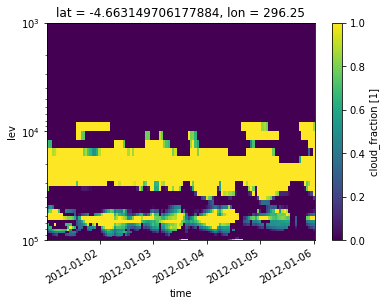

In [74]:
num_days = 5
_dm['clfr'].isel(time=slice(0,24*num_days)).plot(x='time',yscale='log',ylim=[1e5,1000] )#ylim=[47,0])

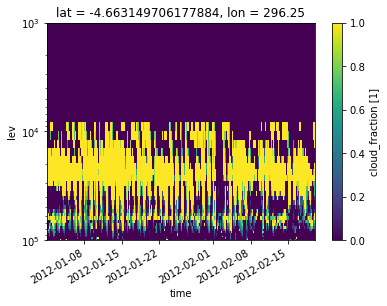

In [75]:
num_days = 50
_dm['clfr'].isel(time=slice(0,24*num_days)).plot(x='time',yscale='log',ylim=[1e5,1000] )#ylim=[47,0])

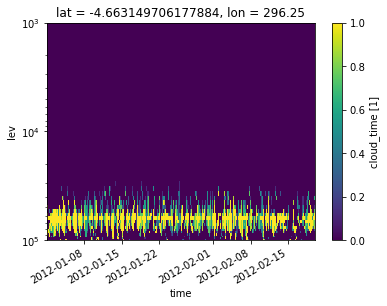

In [76]:
num_days = 50
_dm['cl_time'].isel(time=slice(0,24*num_days)).plot(x='time',yscale='log',ylim=[1e5,1000] )#ylim=[47,0])

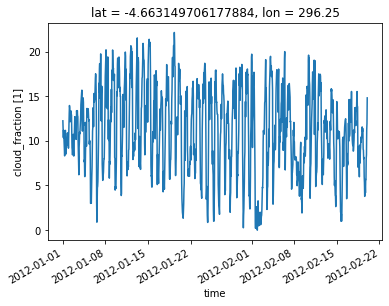

In [77]:
_dm['clfr'].isel(time=slice(0,24*num_days)).sum('lev').plot()

In [78]:
_dm['test_measure_2'] = _dm['clfr'].sum('lev')

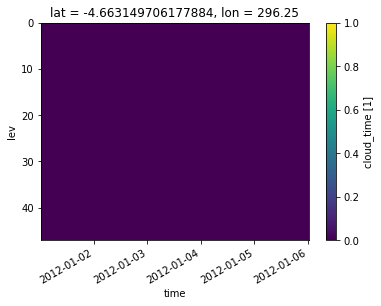

In [79]:
num_days = 5
_dm['cl_time'].isel(time=slice(0,24*num_days)).plot(x='time', ylim=[47,0])

In [81]:
_dm['test_measure']=_dm['diff'].where(_dm['diff']<0).sum('lev')
_dm['test_measure_p']=-_dm['diff'].where(_dm['diff']<0).sum('lev')

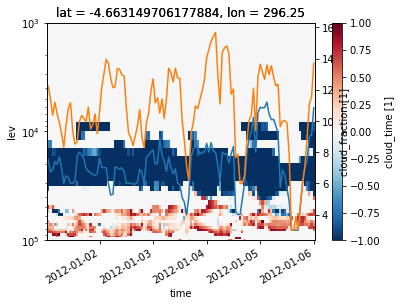

In [82]:
fig, ax = plt.subplots()
_dm['diff'].isel(time=slice(0,24*num_days)).plot(x='time',yscale='log', ylim=[1000e2, 10e2])
ax2 = ax.twinx()
_dm['test_measure_p'].isel(time=slice(0,24*num_days)).plot(ax=ax2)
_dm['test_measure_2'].isel(time=slice(0,24*num_days)).plot(ax=ax2)

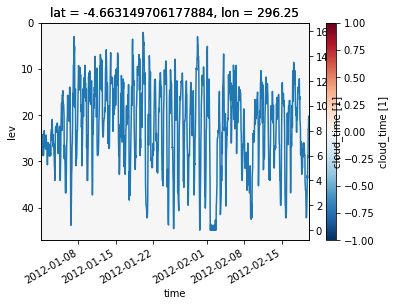

In [83]:
fig, ax = plt.subplots()
_dm['diff'].isel(time=slice(0,24*50)).plot(x='time', ylim=[47,0])
_dm['test_measure_p'].isel(time=slice(0,24*50)).plot(ax=ax.twinx())

In [84]:
_dm['cl_time'].max('lev')

<xarray.DataArray 'cl_time' (time: 15168)>
dask.array<nanmax-aggregate, shape=(15168,), dtype=float32, chunksize=(15168,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 -4.663
    lon      float64 296.2
  * time     (time) datetime64[ns] 2012-01-01T00:52:30 ... 2018-03-31T23:52:30
Attributes:
    long_name:      cloud_time
    units:          1
    _FillValue:     -9e+33
    missing_value:  -9e+33
    description:    cloud time

In [85]:
_dm['cwp_incld'] = _dm['cwp']/_dm['cl_time'].max('lev')
_dm['cwp_incld']  = _dm['cwp_incld'].where(_dm['cl_time'].max('lev')>.1)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(array([9.401e+03, 3.228e+03, 9.510e+02, 3.280e+02, 1.220e+02, 7.700e+01,
        2.700e+01, 9.000e+00, 5.000e+00, 6.000e+00]),
 array([-9.3865743e-18,  1.1509911e-01,  2.3019822e-01,  3.4529734e-01,
         4.6039644e-01,  5.7549554e-01,  6.9059467e-01,  8.0569375e-01,
         9.2079288e-01,  1.0358920e+00,  1.1509911e+00], dtype=float32),
 <BarContainer object of 10 artists>)

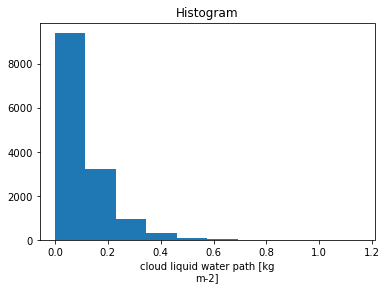

In [86]:
_dm['cwp_incld'].plot.hist()

In [87]:
import numpy as np

In [88]:
_dm['temp_ct'] = _dm['tempair'].where(_dm['cl_time']>.1).min('lev')

In [89]:
_dm['temp_ct_cf'] = _dm['tempair'].where(_dm['clfr']>.1).min('lev')

In [98]:
_dmf = _dm[['cwp_incld','cwp','cod','test_measure_p','test_measure_2','temp_ct', 'temp_ct_cf']].to_dataframe()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [99]:
_dmf['cwp_bin'] = pd.cut(_dmf['cwp_incld'], bins = np.linspace(.01,.350, 10))
_dmf['cwp_bn'] = _dmf['cwp_bin'].apply(lambda x: x.mid)

In [100]:
_dmf['test_bin'] = pd.cut(_dmf['test_measure_p'], bins = np.arange(15))
_dmf['test_bn'] = _dmf['test_bin'].apply(lambda x: x.mid)

<AxesSubplot:ylabel='Frequency'>

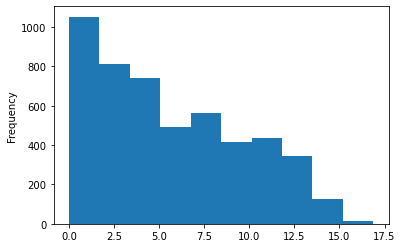

In [101]:
_dmf['test_measure_p'].sample(5000).plot.hist()

<AxesSubplot:ylabel='Frequency'>

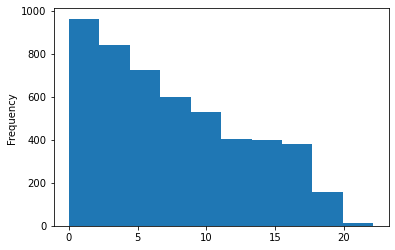

In [102]:
_dmf['test_measure_2'].sample(5000).plot.hist()

<AxesSubplot:ylabel='Frequency'>

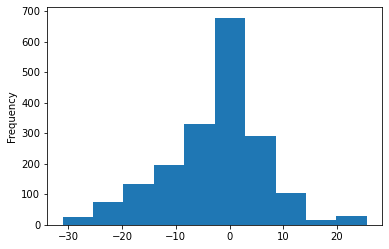

In [109]:
(_dmf['temp_ct']-273.15).sample(2000).plot.hist()

<AxesSubplot:ylabel='Frequency'>

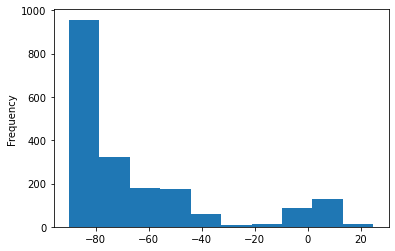

In [108]:
(_dmf['temp_ct_cf']-273.15).sample(2000).plot.hist()

<AxesSubplot:ylabel='Frequency'>

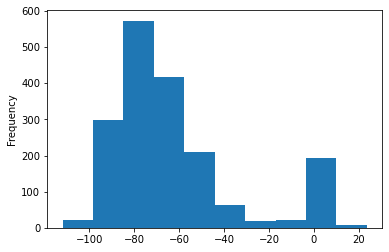

In [110]:
(_dmf['temp_ct_cf']-_dmf['temp_ct']).sample(2000).plot.hist()

In [95]:
import seaborn as sns

<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

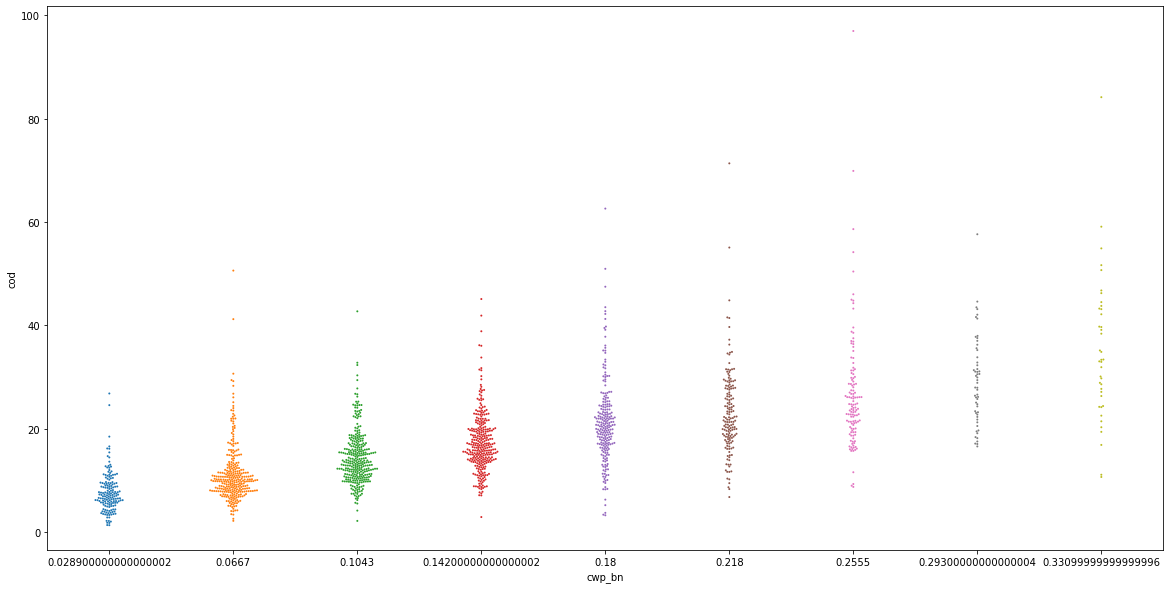

In [103]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['test_measure_2'] > 15]#.sample(2000)

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=2)

<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

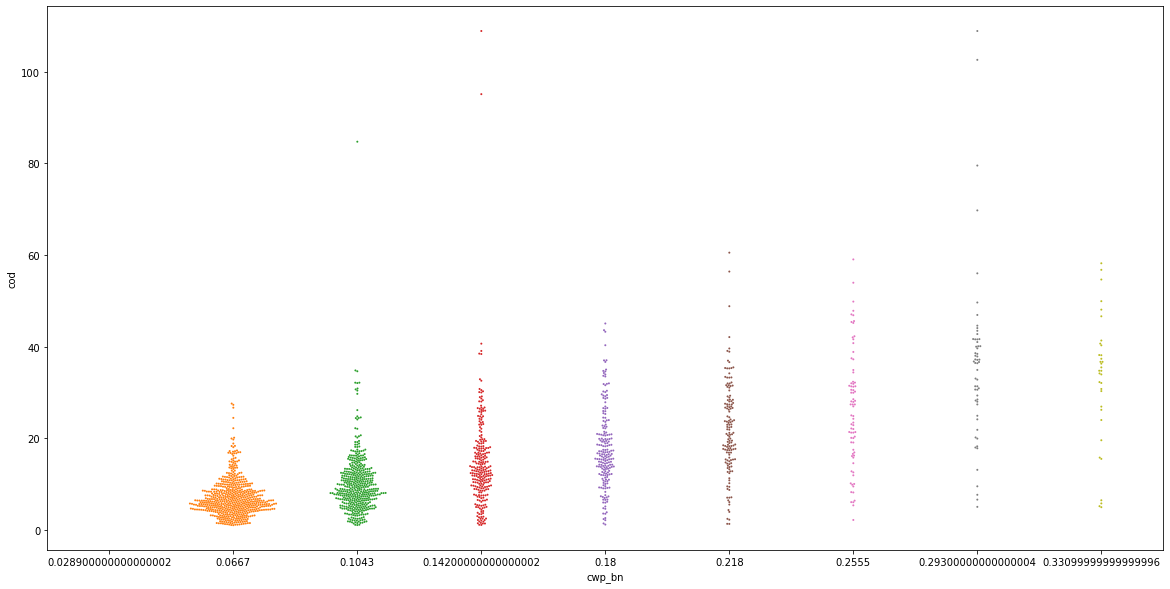

In [104]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['cod']>1]
_dmfl = _dmfl[_dmfl['cwp_incld']>.05]
_dmfl = _dmfl[_dmfl['test_measure_2']<10]
_dmfl = _dmfl[_dmfl['test_measure_p']<10]
_dmfl = _dmfl[_dmfl['temp_ct']>(273.15-15)]
_dmfl = _dmfl.sample(2000)

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=2)

<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

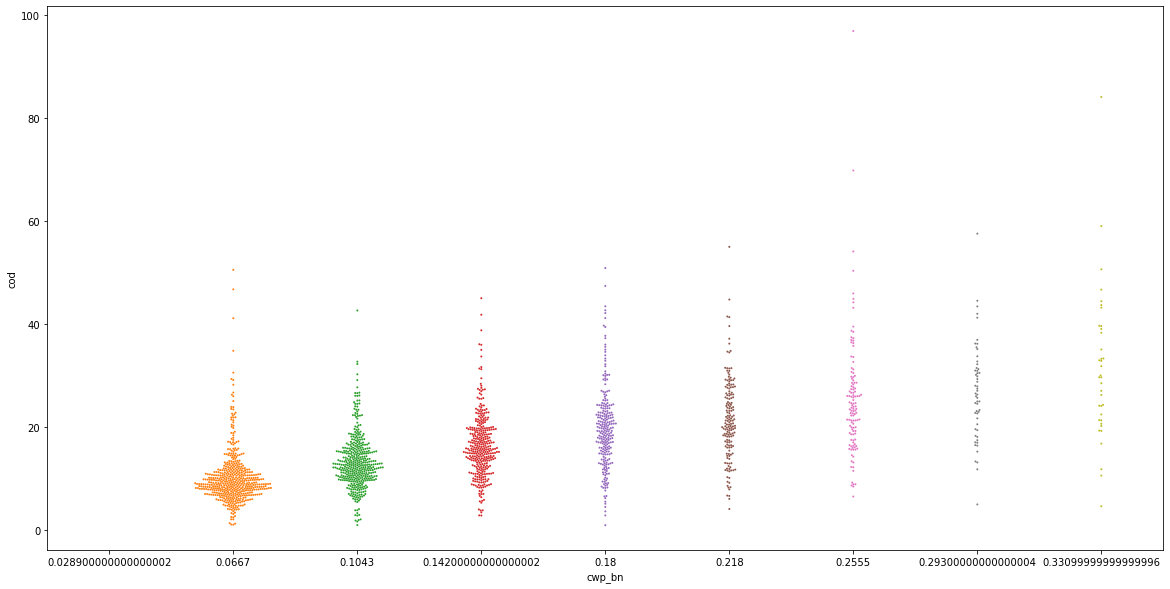

In [229]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['cod']>1]
_dmfl = _dmfl[_dmfl['cwp_incld']>.05]
_dmfl = _dmfl[_dmfl['test_measure_2']>10]
_dmfl = _dmfl[_dmfl['test_measure_p']>10]
_dmfl = _dmfl.sample(2000)

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=2)

In [ ]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['cod']>1]
_dmfl = _dmfl[_dmfl['cwp_incld']>.05]
_dmfl = _dmfl[_dmfl['test_measure_2']>10]
_dmfl = _dmfl[_dmfl['test_measure_p']>10]
_dmfl = _dmfl.sample(2000)

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=2)

<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

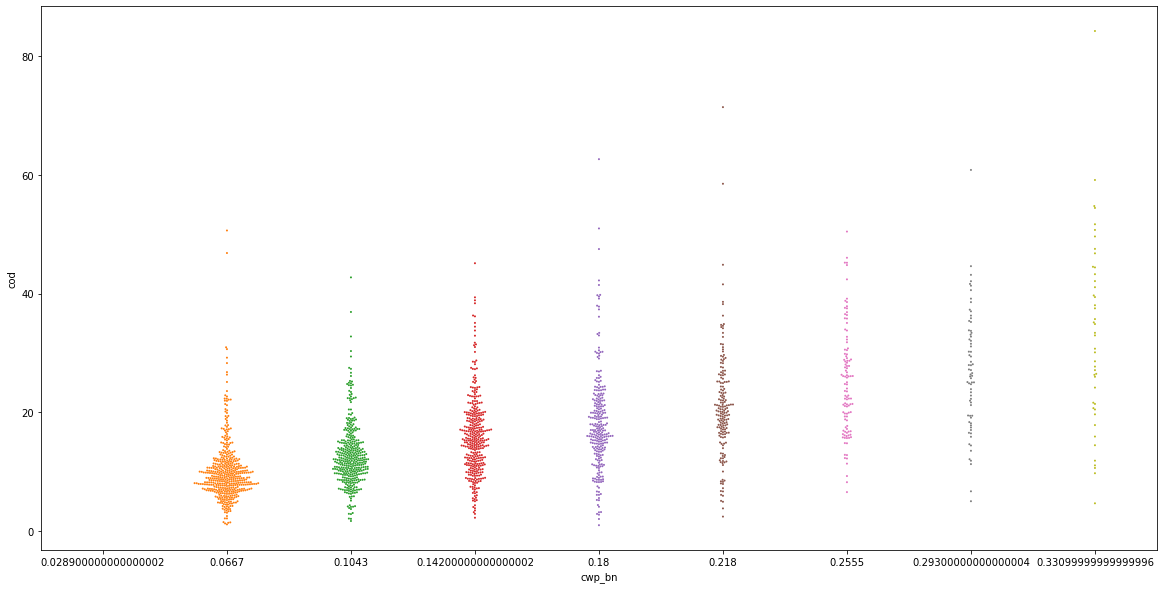

In [224]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['cod']>1]
_dmfl = _dmfl[_dmfl['cwp_incld']>.05]
_dmfl = _dmfl[_dmfl['test_measure_2'] > 10].sample(2000)

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=2)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

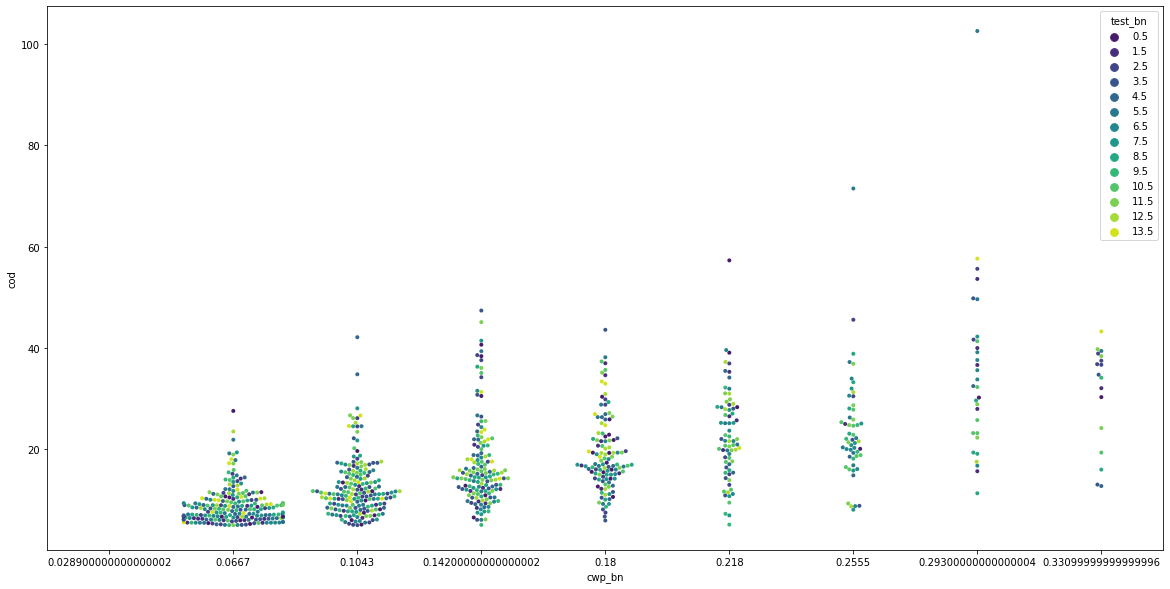

In [123]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['test_measure_p'] < 20].sample(2000)
_dmfl = _dmfl[_dmfl['cod']>5]
_dmfl = _dmfl[_dmfl['cwp']>.05]
sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=4, hue='test_bn', palette='viridis')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

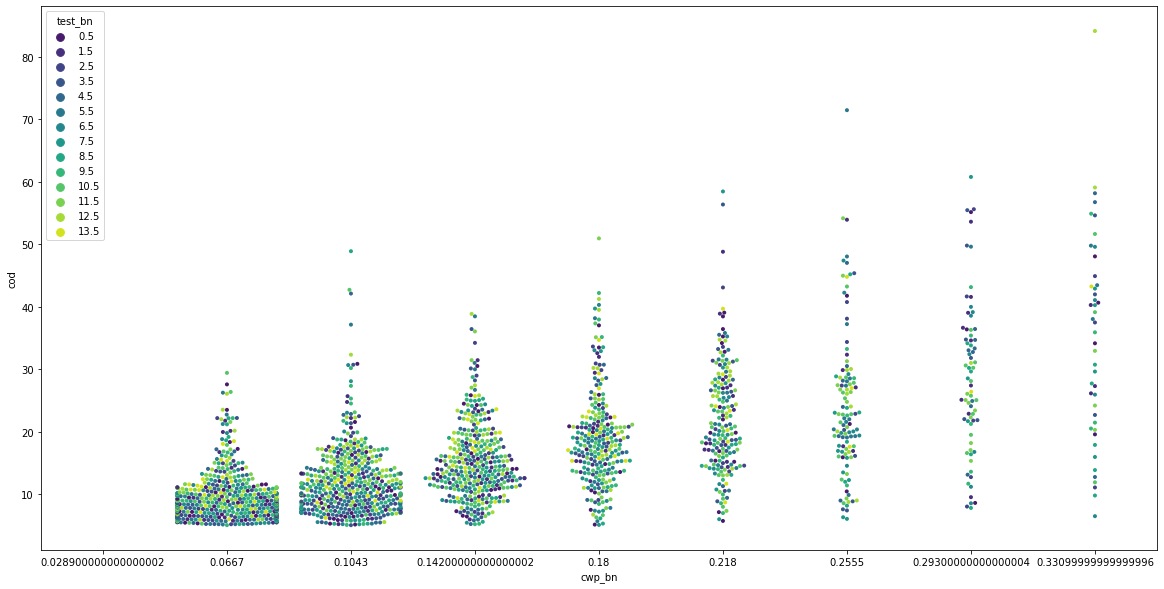

In [124]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf[_dmf['test_measure_p'] < 20].sample(5000)
_dmfl = _dmfl[_dmfl['cod']>5]
_dmfl = _dmfl[_dmfl['cwp']>.05]
sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax, size=4, hue='test_bn', palette='viridis')

<AxesSubplot:xlabel='test_bn', ylabel='cod'>

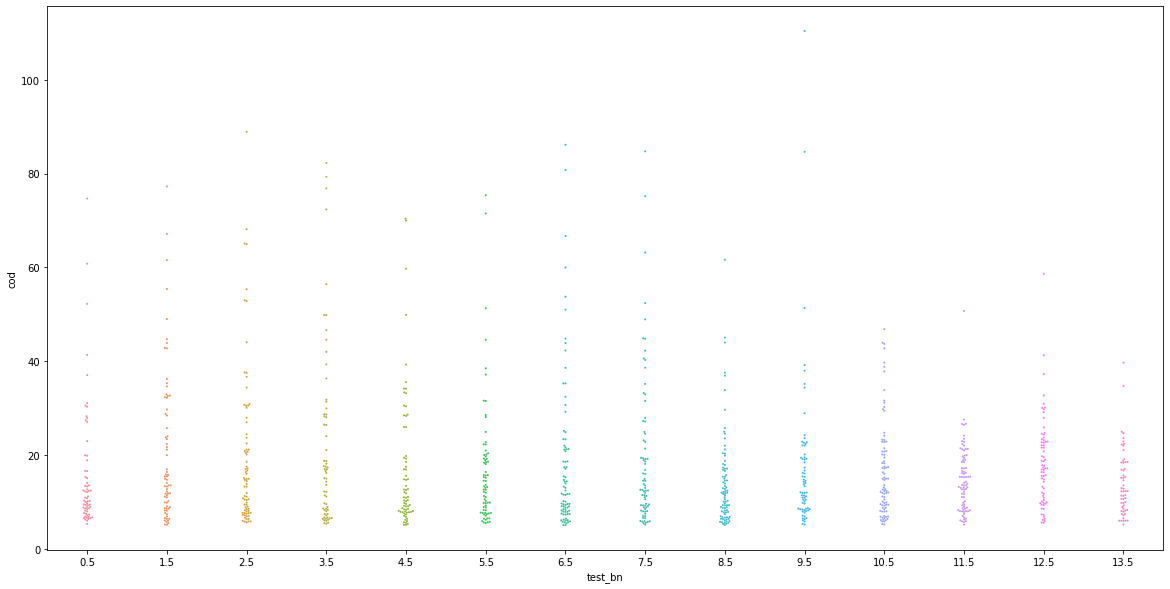

In [115]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf.sample(2000)
_dmfl = _dmfl[_dmfl['cod']>5]
_dmfl = _dmfl[_dmfl['cwp']>0]

sns.swarmplot(x='test_bn', y ='cod', data = _dmfl, ax = ax, size=2)

<AxesSubplot:xlabel='test_bn', ylabel='cwp_incld'>

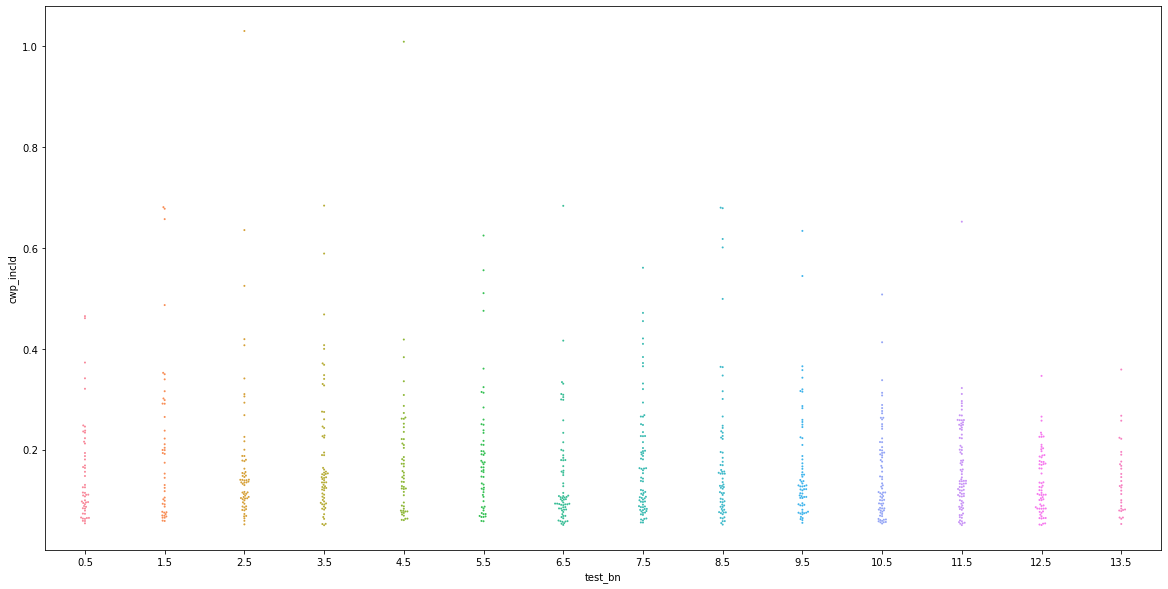

In [116]:
fig, ax = plt.subplots(figsize=[20,10])
_dmfl = _dmf.sample(2000)
_dmfl = _dmfl[_dmfl['cod']>5]
_dmfl = _dmfl[_dmfl['cwp_incld']>.050]
sns.swarmplot(x='test_bn', y ='cwp_incld', data = _dmfl, ax = ax, size=2)

In [ ]:
fig, ax = plt.subplots(figsize=[20,20])
_dmfl = _dmf[_dmf['test_measure_p'] < 10].iloc

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 91.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 89.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 85.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 70.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

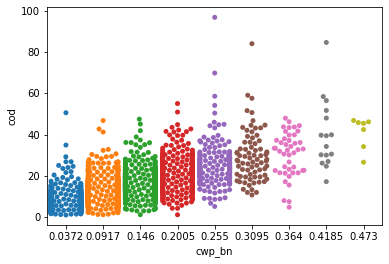

In [72]:
fig, ax = plt.subplots(figsize=[10,10])
_dmfl = _dmf[_dmf['test_measure_p'] > 10]

sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl, ax = ax)

KeyboardInterrupt: 

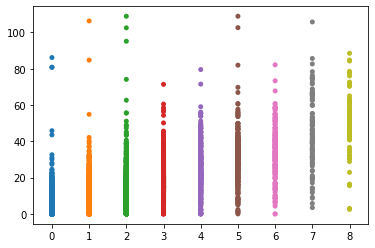

In [73]:
_dmfl = _dmf[_dmf['test_measure_p']<10]
sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl)

In [ ]:
_dmfl = _dmf[_dmf['test_measure_p']<10]
sns.swarmplot(x='cwp_bn', y ='cod', data = _dmfl)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 98.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 98.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 98.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 98.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='cwp_bn', ylabel='cod'>

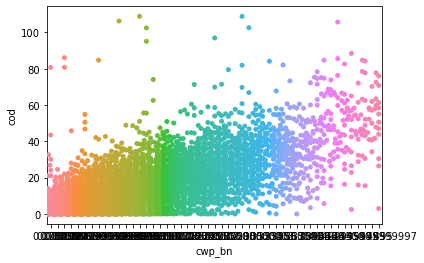

In [63]:
sns.swarmplot(x='cwp_bn', y ='cod', data = _dmf)

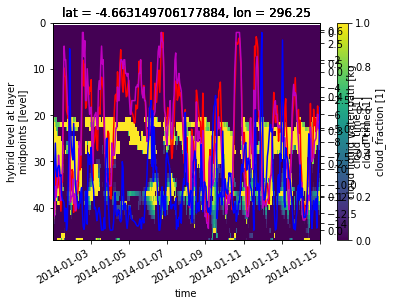

In [31]:
fi, ax = plt.subplots()
_dm['clfr'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)
_dm['diff'].sum('lev').sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='r', ax = ax.twinx())
_dm['test_measure'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='m', ax = ax.twinx())
_dm['cwp'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='b', ax = ax.twinx())

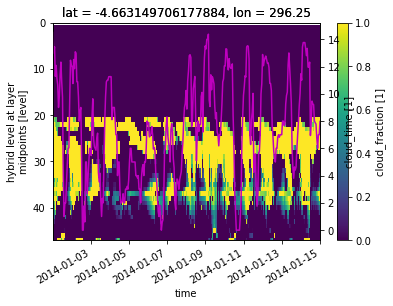

In [32]:
fi, ax = plt.subplots()
_dm['clfr'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)
#_dm['diff'].sum('lev').sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='r', ax = ax.twinx())
(-_dm['test_measure']).sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='m', ax = ax.twinx())
#_dm['cwp'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='b', ax = ax.twinx())

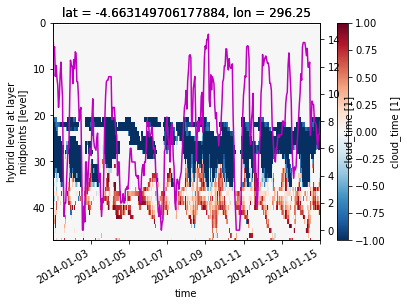

In [33]:
fi, ax = plt.subplots()
_dm['diff'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)
#_dm['diff'].sum('lev').sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='r', ax = ax.twinx())
(-_dm['test_measure']).sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='m', ax = ax.twinx())
#_dm['cwp'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='b', ax = ax.twinx())

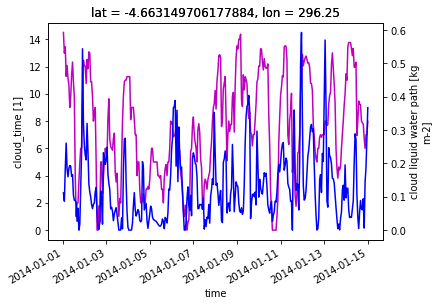

In [34]:
fi, ax = plt.subplots()
#_dm['clfr'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)
#_dm['diff'].sum('lev').sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='r', ax = ax.twinx())
(-_dm['test_measure']).sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='m', ax = ax)
_dm['cwp'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='b', ax = ax.twinx())

In [228]:
_dm['temp_ct'] = _dm['tempair'].where(_dm['cl_time']>0.011).min('lev')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


(array([ 180.,  609.,  925., 1626., 2263., 4963., 2358.,  876.,  123.,
         231.]),
 array([-32.684235 , -26.751654 , -20.819073 , -14.886493 ,  -8.953913 ,
         -3.0213318,   2.9112487,   8.843829 ,  14.77641  ,  20.70899  ,
         26.641571 ], dtype=float32),
 <BarContainer object of 10 artists>)

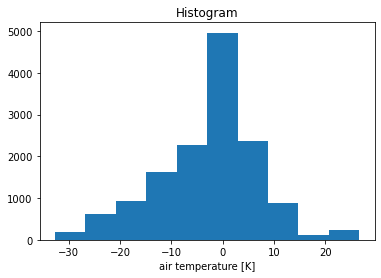

In [71]:
(_dm['temp_ct']-273.15).plot.hist()

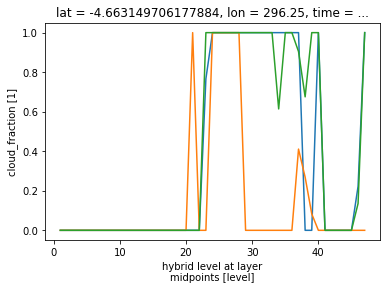

In [36]:
_dm['clfr'].isel(time=200).plot()
_dm['clfr'].isel(time=210).plot()
_dm['clfr'].isel(time=220).plot()

In [73]:
_dmslev=_dm.sel(lev=slice(23,38))

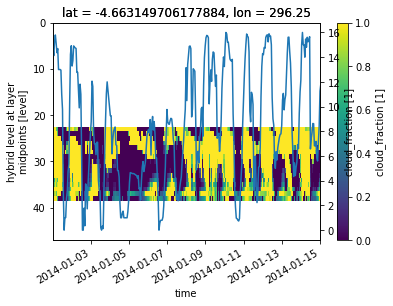

In [74]:
fi, ax = plt.subplots()

_dmslev['clfr'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)
_dmslev['clfr'].sum('lev').plot(x='time', ax = ax.twinx())

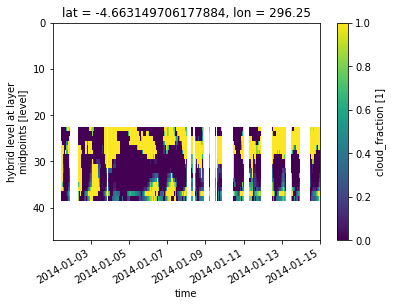

In [75]:
fi, ax = plt.subplots()

_dmslev['clfr'].where(_dmslev['clfr'].sum('lev')<12).sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)

In [76]:
_dm['criteria'] = _dmslev['clfr'].sum('lev')<10

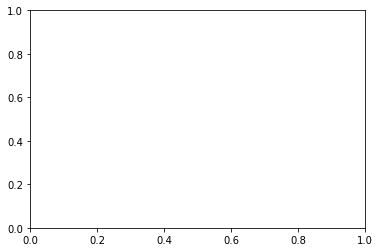

In [77]:
fi, ax = plt.subplots()

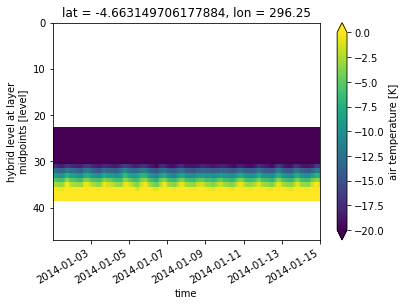

In [78]:
(_dmslev['tempair']-273.15).sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], vmax=0, vmin=-20)

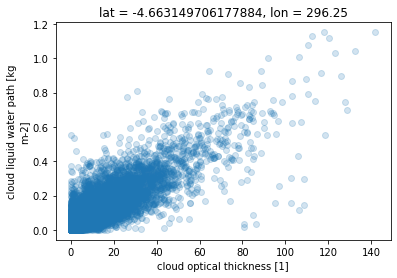

In [108]:
_dm.plot.scatter(x='cod',y='cwp', alpha=0.2)

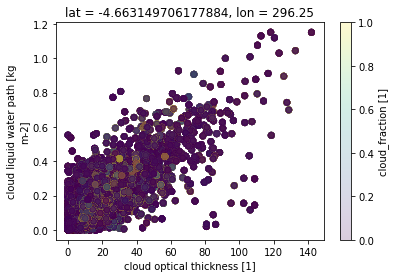

In [109]:
_dm.plot.scatter(x='cod',y='cwp', alpha=0.2, hue='clfr')

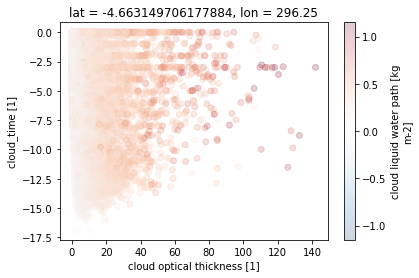

In [113]:
_dm.plot.scatter(x='cod',y='test_measure', alpha=0.2, hue='cwp')

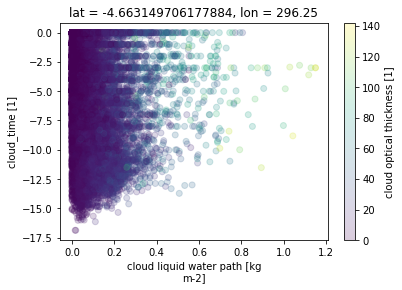

In [114]:
_dm.plot.scatter(x='cwp',y='test_measure', alpha=0.2, hue='cod')

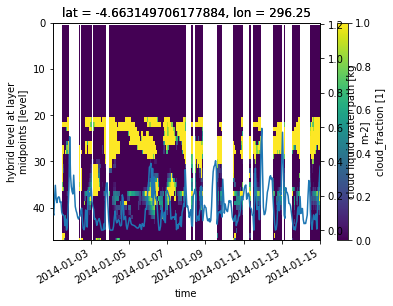

In [79]:
fi, ax = plt.subplots()

_dm['clfr'].where(_dm['criteria']).sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)

_dm['cwp'].plot(ax=ax.twinx())

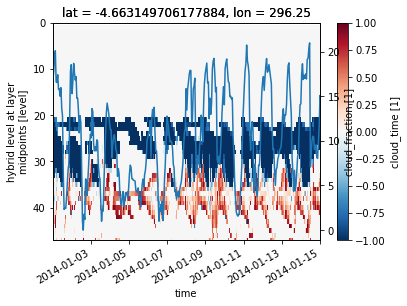

In [80]:
fi, ax = plt.subplots()

_dm['diff'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)

_dm['clfr'].sum('lev').plot(ax=ax.twinx())

In [81]:
_df = _dm[['diff','cwp','cod','test_measure', 'criteria','temp_ct']].sum('lev').to_dataframe()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [82]:
import seaborn as sns



In [83]:
_df

diff       cwp        cod  test_measure  criteria  \
time                                                                         
2012-01-01 00:52:30 -3.991999  0.296052  27.228453     -7.523832     False   
2012-01-01 01:52:30 -4.335583  0.205798  28.666080     -6.731660     False   
2012-01-01 02:52:30 -3.737811  0.170126  19.326342     -6.873736      True   
2012-01-01 03:52:30 -5.579173  0.190083  18.756506     -7.401873      True   
2012-01-01 04:52:30 -4.716409  0.103335  22.083645     -7.236035      True   
...                       ...       ...        ...           ...       ...   
2018-03-31 19:52:30 -1.182910  0.042848   0.179984     -3.432910      True   
2018-03-31 20:52:30 -0.444676  0.039224   1.153095     -2.000000      True   
2018-03-31 21:52:30 -1.778937  0.009959   1.374557     -2.439349      True   
2018-03-31 22:52:30 -4.755913  0.110651   2.399392     -6.730278      True   
2018-03-31 23:52:30 -2.631092  0.160736   2.929387     -7.263385      True   

                        temp_ct      lat     lon  
time                                              
2012-01-01 00:52:30  267.878113 -4.66315  296.25  
2012-01-01 01:52:30  267.710419 -4.66315  296.25  
2012-01-01 02:52:30  267.522369 -4.66315  296.25  
2012-01-01 03:52:30  267.373413 -4.66315  296.25  
2012-01-01 04:52:30  273.160767 -4.66315  296.25  
...                         ...      ...     ...  
2018-03-31 19:52:30  276.916107 -4.66315  296.25  
2018-03-31 20:52:30  275.100403 -4.66315  296.25  
2018-03-31 21:52:30  275.048401 -4.66315  296.25  
2018-03-31 22:52:30  255.229294 -4.66315  296.25  
2018-03-31 23:52:30  249.744919 -4.66315  296.25  

[15168 rows x 8 columns]

In [84]:
_df['crit2'] = _df['criteria']&(_df['temp_ct']>-15+273.15)

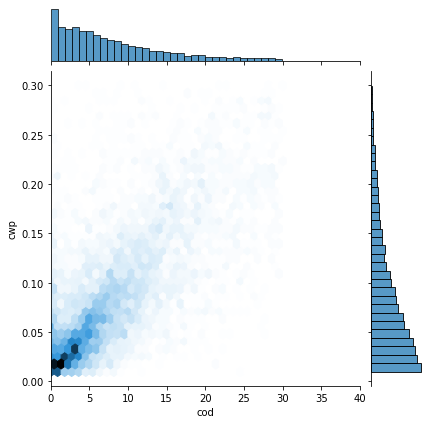

In [85]:
sns.jointplot(x='cod',y='cwp', data = _df[(((_df['cwp']>.01)&(_df['cwp']<.3))&_df['crit2'])& (_df['cod']<30)], kind='hex', xlim=[0,40])

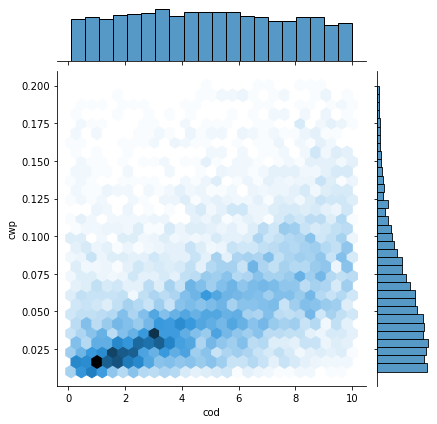

In [86]:
sns.jointplot(x='cod',y='cwp', data = _df[(((_df['cwp']>.01)&(_df['cwp']<.2)))& ((_df['cod']<10)&(_df['cod']>0.1))], kind='hex', )

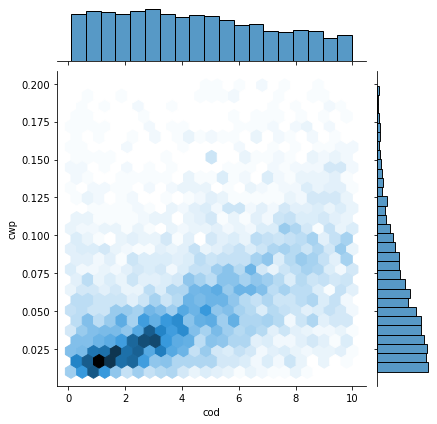

In [87]:
sns.jointplot(x='cod',y='cwp', data = _df[(((_df['cwp']>.01)&(_df['cwp']<.2))&_df['crit2'])& ((_df['cod']<10)&(_df['cod']>0.1))], kind='hex', )

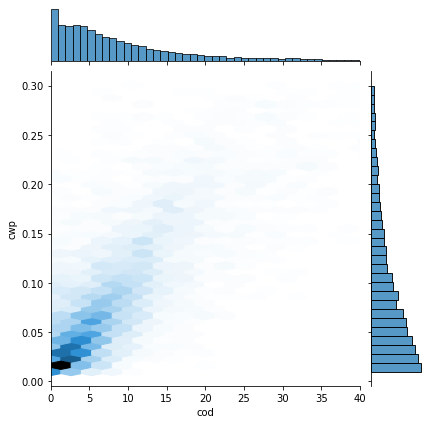

In [88]:
sns.jointplot(x='cod',y='cwp', data = _df[((_df['cwp']>.01)&(_df['cwp']<.3))&_df['criteria']], kind='hex',xlim=[0,40])

In [127]:
_df['test_measure_pos'] = -_df['test_measure']

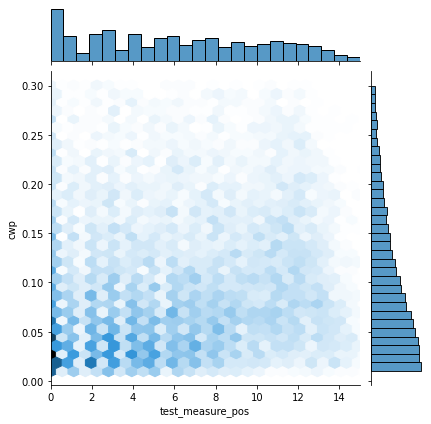

In [129]:
sns.jointplot(x='test_measure_pos',y='cwp', data = _df[((_df['cwp']>.01)&(_df['cwp']<.3))], kind='hex',xlim=[0,15])

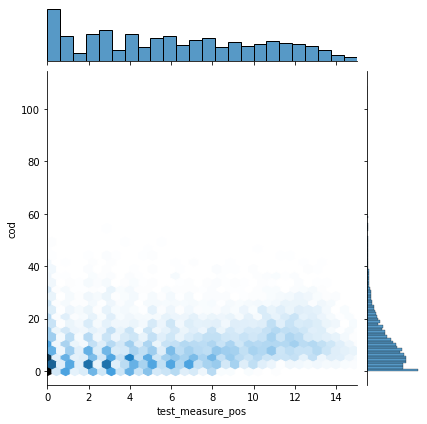

In [131]:
sns.jointplot(x='test_measure_pos',y='cod', data = _df[((_df['cwp']>.01)&(_df['cwp']<.3))], kind='hex',xlim=[0,15])

In [136]:
import numpy as np

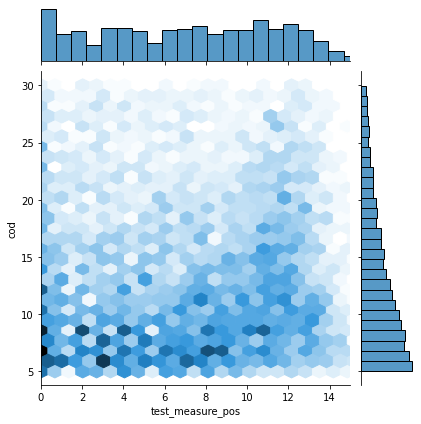

In [142]:
sns.jointplot(x='test_measure_pos',y='cod', data = _df[((_df['cod']>5)&(_df['cod']<30))], kind='hex',xlim=[0,15], )

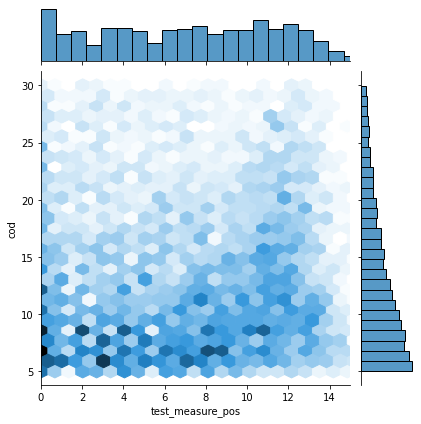

In [143]:
sns.jointplot(x='test_measure_pos',y='cod', data = _df[((_df['cod']>5)&(_df['cod']<30))], kind='hex',xlim=[0,15], )

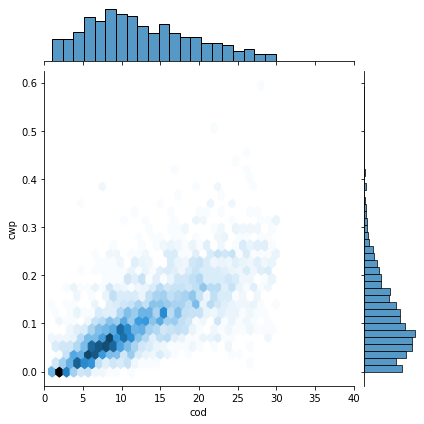

In [152]:
_df_test = (_df[
    ((_df['cod']>1)&(_df['cod']<30)
     &(_df['test_measure_pos']>10)
    )
]
)
sns.jointplot(x='cod',y='cwp', data = _df_test, kind='hex',xlim=[0,40])

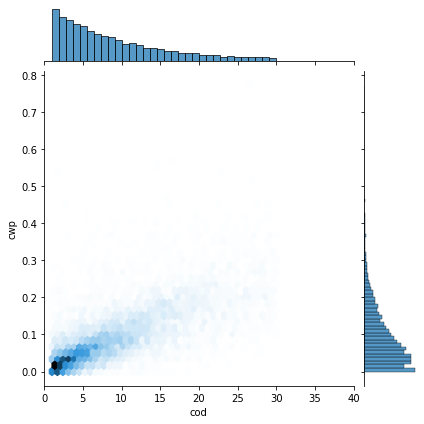

In [151]:
_df_test = (_df[
    ((_df['cod']>1)&(_df['cod']<30)
     &(_df['test_measure_pos']<10)
    )
]
)
sns.jointplot(x='cod',y='cwp', data = _df_test, kind='hex',xlim=[0,40])

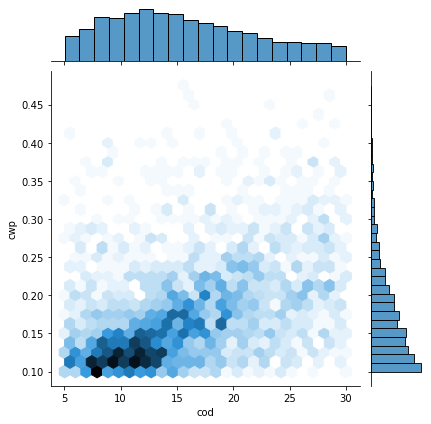

In [148]:
_df_test = (_df[
    ((_df['cod']>5)&(_df['cod']<30)
     &(_df['test_measure_pos']<10)
    &(_df['cwp']>.1)&(_df['cwp']<.5)
    )
]
)
sns.jointplot(x='cod',y='cwp', data = _df_test, kind='hex')

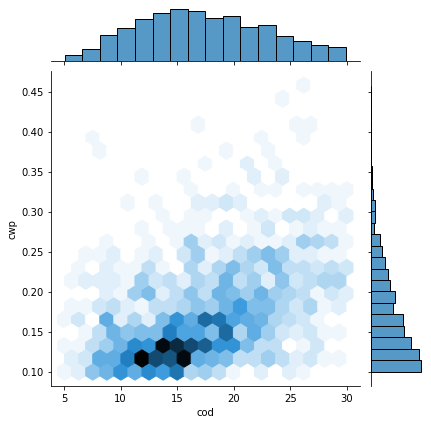

In [149]:
_df_test = (_df[
    ((_df['cod']>5)&(_df['cod']<30)
     &(_df['test_measure_pos']>10)
    &(_df['cwp']>.1)&(_df['cwp']<.5)
    )
]
)
sns.jointplot(x='cod',y='cwp', data = _df_test, kind='hex')

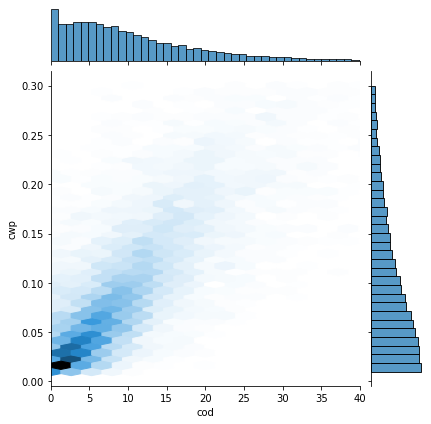

In [121]:
sns.jointplot(x='cod',y='cwp', data = _df[((_df['cwp']>.01)&(_df['cwp']<.3))], kind='hex',xlim=[0,40])

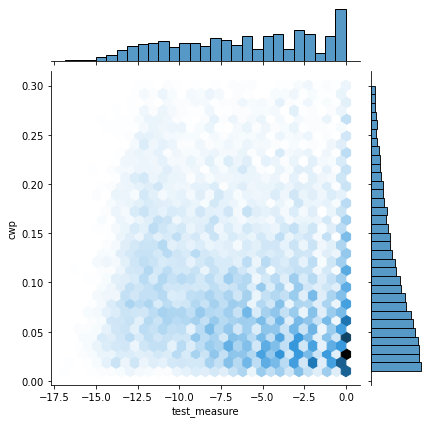

In [89]:
sns.jointplot(x='test_measure',y='cwp', data = _df[(_df['cwp']>.01)&(_df['cwp']<.3)], kind='hex')

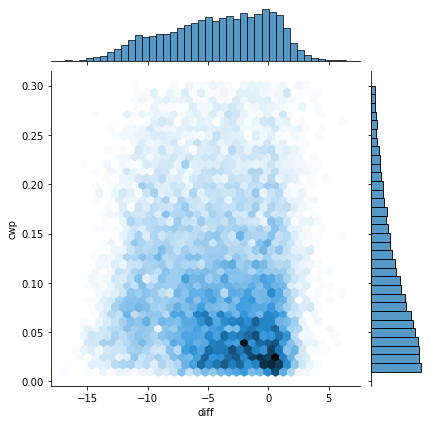

In [90]:
sns.jointplot(x='diff',y='cwp', data = _df[(_df['cwp']>.01)&(_df['cwp']<.3)], kind='hex')

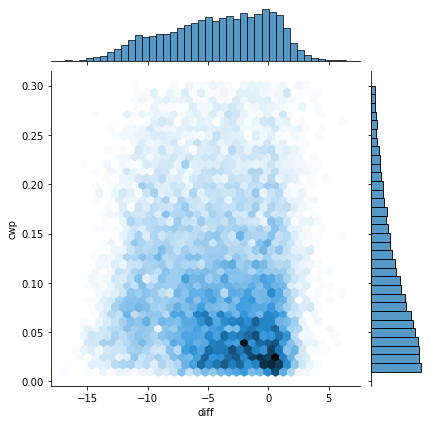

In [91]:
sns.jointplot(x='diff',y='cwp', data = _df[(_df['cwp']>.01)&(_df['cwp']<.3)], kind='hex')

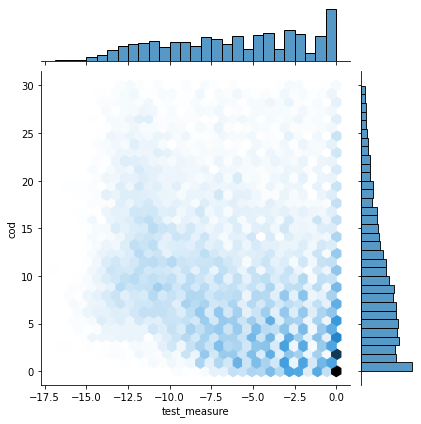

In [92]:
sns.jointplot(x='test_measure',y='cod', data = _df[(_df['cwp']>.01)&(_df['cod']<30)], kind='hex')

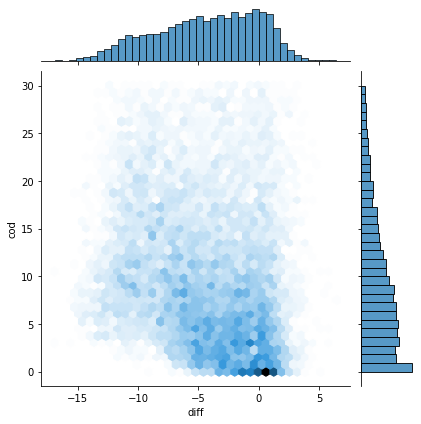

In [93]:
sns.jointplot(x='diff',y='cod', data = _df[(_df['cwp']>.01)&(_df['cod']<30)], kind='hex')

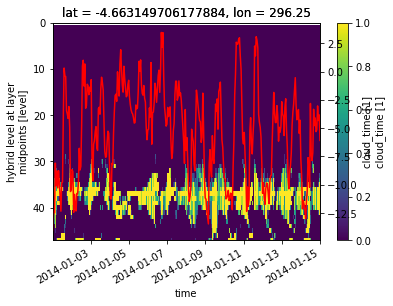

In [94]:
fi, ax = plt.subplots()
_dm['cl_time'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)
_dm['diff'].sum('lev').sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='r', ax = ax.twinx())

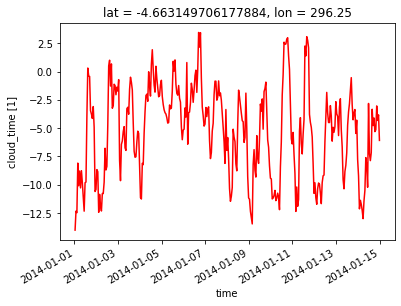

In [95]:
_dm['diff'].sum('lev').sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  c='r')

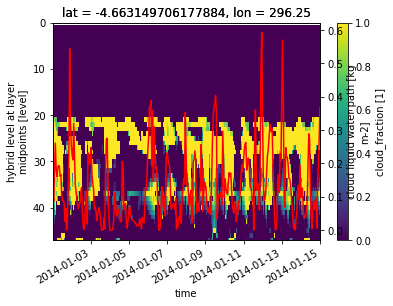

In [96]:
fi, ax = plt.subplots()
_dm['clfr'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0], ax=ax)

_dm['cwp'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time',  ax = ax.twinx(), c='r')

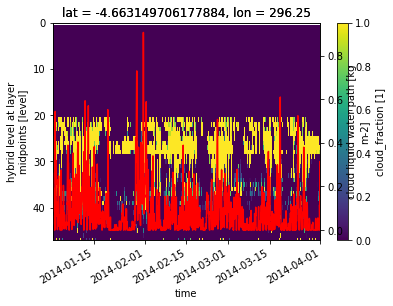

In [97]:
fi, ax = plt.subplots()
_dm['clfr'].sel(time=slice('2014-01-01','2014-05-14')).plot(x='time', ylim=[47,0], ax=ax)

_dm['cwp'].sel(time=slice('2014-01-01','2014-05-14')).plot(x='time',  ax = ax.twinx(), c='r')

In [ ]:
_dm['cl_top_tmp'] = _dm['tempair'].where(_dm['clfr']>.5).min('lev')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


(array([7317., 2540., 1349., 1176.,  389.,   55.,   52.,  506.,  652.,
          43.]),
 array([-90.45558  , -78.81601  , -67.17644  , -55.53686  , -43.897285 ,
        -32.257713 , -20.61814  ,  -8.978566 ,   2.6610076,  14.300581 ,
         25.940155 ], dtype=float32),
 <BarContainer object of 10 artists>)

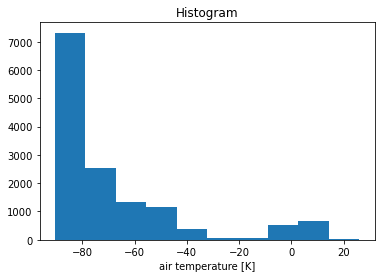

In [154]:
(_dm['cl_top_tmp']-273.15).plot.hist()

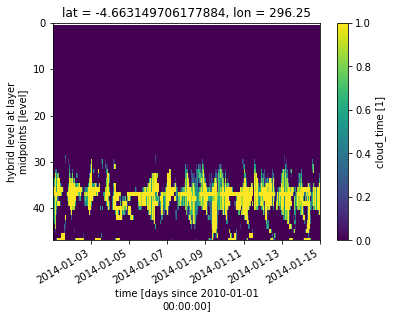

In [142]:
_dm['cl_time'].sel(time=slice('2014-01-01','2014-01-14')).plot(x='time', ylim=[47,0])

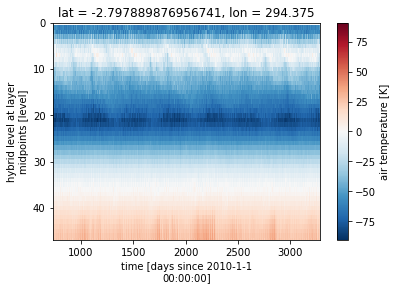

In [59]:
(ds_all['tempair'].isel(lat=0,lon=0)-273.15).plot(x='time', ylim=[47,0])

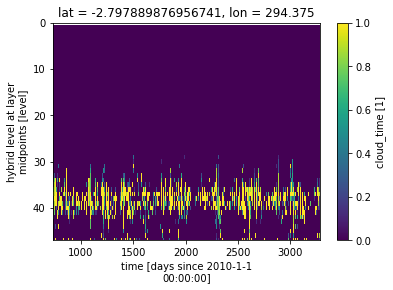

In [60]:
(ds_all['cl_time'].isel(lat=0,lon=0)).plot(x='time', ylim=[47,0])

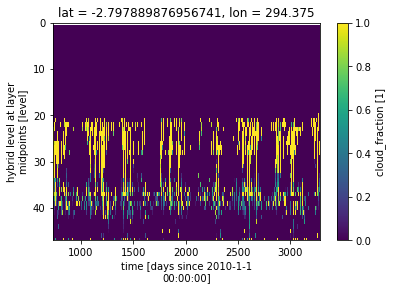

In [61]:
(ds_all['clfr'].isel(lat=0,lon=0)).plot(x='time', ylim=[47,0])

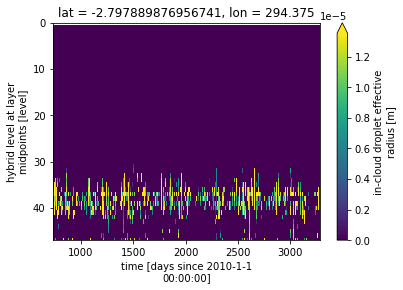

In [62]:
(ds_all['ceff'].isel(lat=0,lon=0)).plot(x='time', ylim=[47,0], robust=True)

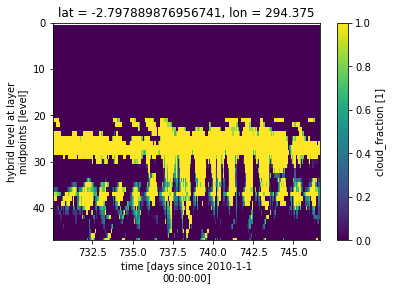

In [63]:
(ds_all['clfr'].isel(lat=0,lon=0)).isel(time=slice(0,400)).plot(x='time', ylim=[47,0])

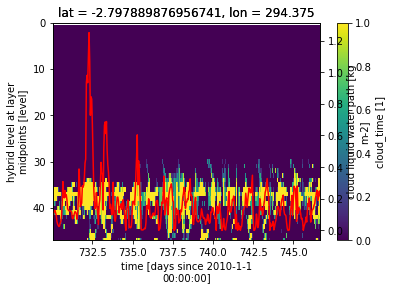

In [64]:
fi, ax = plt.subplots()
(ds_all['cl_time'].isel(lat=0,lon=0)).isel(time=slice(0,400)).plot(x='time', ylim=[47,0])

ds_all['cwp'].isel(lat=0,lon=0).isel(time=slice(0,400)).plot(ax=ax.twinx(), c='r')

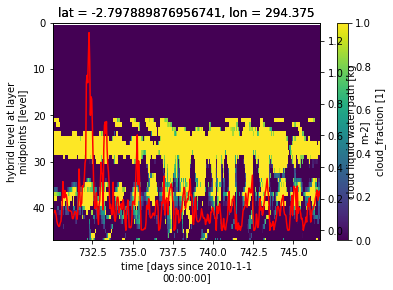

In [65]:
fi, ax = plt.subplots()
(ds_all['clfr'].isel(lat=0,lon=0)).isel(time=slice(0,400)).plot(x='time', ylim=[47,0])

ds_all['cwp'].isel(lat=0,lon=0).isel(time=slice(0,400)).plot(ax=ax.twinx(), c='r')

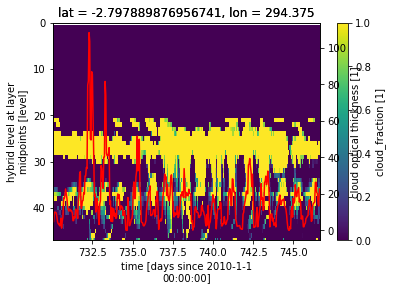

In [66]:
fi, ax = plt.subplots()
(ds_all['clfr'].isel(lat=0,lon=0)).isel(time=slice(0,400)).plot(x='time', ylim=[47,0])

ds_all['cod'].isel(lat=0,lon=0).isel(time=slice(0,400)).plot(ax=ax.twinx(), c='r')

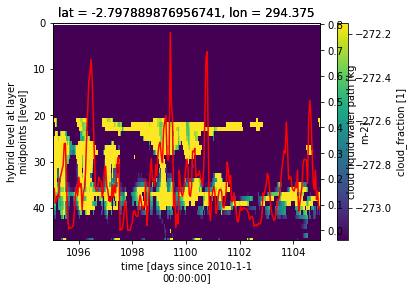

In [67]:
fi, ax = plt.subplots()
from_days = 365
num_days = 375
(ds_all['clfr'].isel(lat=0,lon=0)-273.15).isel(time=slice(24*from_days,24*num_days)).plot(x='time', ylim=[47,0])

ds_all['cwp'].isel(lat=0,lon=0).isel(time=slice(24*from_days,24*num_days)).plot(ax=ax.twinx(), c='r')

In [68]:
ds_all['min_cl_temp'] = ds_all['tempair'].where(ds_all['clfr']>0.9).min('lev')
ds_all['min_clt_temp'] = ds_all['tempair'].where(ds_all['cl_time']>0.9).min('lev')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


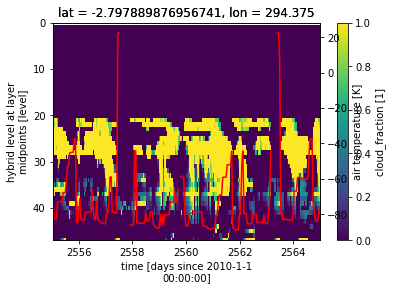

In [69]:
fi, ax = plt.subplots()
from_days = 365*5
num_days = 365*5+10
(ds_all['clfr'].isel(lat=0,lon=0)).isel(time=slice(24*from_days,24*num_days)).plot(x='time', ylim=[47,0])

#ds_all['cwp'].isel(lat=0,lon=0).isel(time=slice(24*from_days,24*num_days)).plot(ax=ax.twinx(), c='r')
(ds_all['min_cl_temp']-273.15).isel(lat=0,lon=0).isel(time=slice(24*from_days,24*num_days)).plot(ax=ax.twinx(), c='r')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


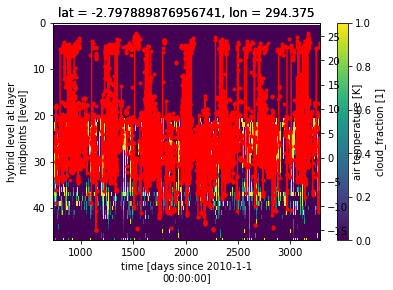

In [70]:
fi, ax = plt.subplots()
from_days = 0#365*5
num_days = 365*7+30
(ds_all['clfr'].isel(lat=0,lon=0)).isel(time=slice(24*from_days,24*num_days)).plot(x='time', ylim=[47,0])

#ds_all['cwp'].isel(lat=0,lon=0).isel(time=slice(24*from_days,24*num_days)).plot(ax=ax.twinx(), c='r')
(ds_all['min_cl_temp']-273.15).where((ds_all['min_cl_temp']-273.15)>-15).isel(lat=0,lon=0).isel(time=slice(24*from_days,24*num_days)).plot(ax=ax.twinx(),marker='.', c='r')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


(array([9282., 5512., 2516., 1977.,  338.,  312.,  257., 5295., 4317.,
         808.]),
 array([-79.99985  , -69.426506 , -58.85317  , -48.279827 , -37.70649  ,
        -27.133148 , -16.559809 ,  -5.9864683,   4.586871 ,  15.160212 ,
         25.733551 ], dtype=float32),
 <BarContainer object of 10 artists>)

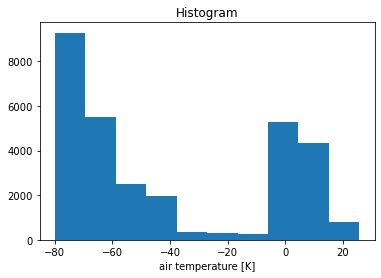

In [71]:
(ds_all['min_cl_temp']-273.15).where((ds_all['min_cl_temp']-273.15)>-80).isel(lat=0,lon=0).plot.hist()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


(array([1.05000e+02, 1.27800e+03, 1.14370e+04, 8.84700e+04, 6.24100e+03,
        2.12840e+04, 8.62490e+04, 1.86928e+05, 2.00018e+05, 7.06000e+03]),
 array([-56.0961  , -38.990517, -21.884937,  -4.779355,  12.326227,
         29.431808,  46.53739 ,  63.64297 ,  80.74855 ,  97.85413 ,
        114.95972 ], dtype=float32),
 <BarContainer object of 10 artists>)

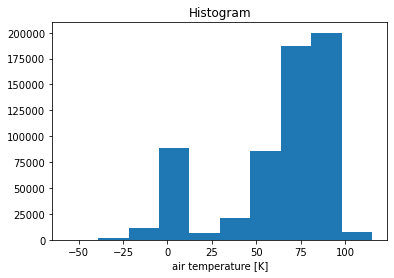

In [73]:
(ds_all['min_clt_temp']-ds_all['min_cl_temp']).plot.hist()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


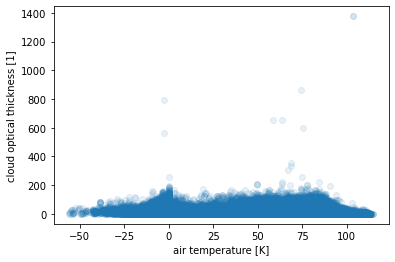

In [75]:
ds_all['diff'] = ds_all['min_clt_temp']-ds_all['min_cl_temp']
ds_all.plot.scatter(x='diff',y='cod', alpha=.1)

In [77]:
ds_all['tempair_incld'] = ds_all['tempair'].where(ds_all['clfr']>0.99)

In [96]:
ds_all['tempair_minlev_incld'] = ds_all['tempair_incld'].min('lev')
ds_all['tempair_medianlev_incld'] = ds_all['tempair_incld'].median('lev')
ds_all['tempair_meanlev_incld'] = ds_all['tempair_incld'].mean('lev')

In [97]:
ds_all['tempair_minlev_incld2'] = ds_all['tempair'].where(ds_all['clfr']>0.9).min('lev')
ds_all['tempair_medianlev_incld2'] = ds_all['tempair'].where(ds_all['clfr']>0.9).median('lev')
ds_all['tempair_meanlev_incld2'] = ds_all['tempair'].where(ds_all['clfr']>0.9).mean('lev')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


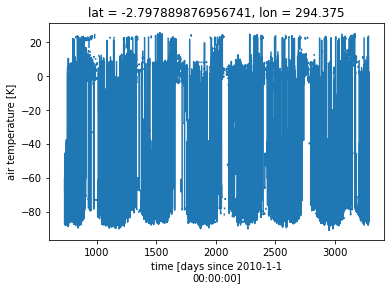

In [89]:
(ds_all['tempair_minlev_incld']-273.15).isel(lat=0,lon=0).plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


(array([13699.,  9023.,  4264.,  3577.,   990.,   277.,   213.,  3592.,
         6125.,   858.]),
 array([-90.90694  , -79.24289  , -67.57884  , -55.91479  , -44.25074  ,
        -32.586693 , -20.922644 ,  -9.258595 ,   2.4054534,  14.069502 ,
         25.733551 ], dtype=float32),
 <BarContainer object of 10 artists>)

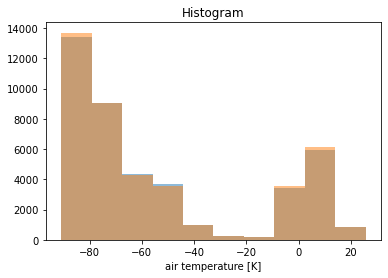

In [90]:
(ds_all['tempair_minlev_incld'].isel(lat=0,lon=0)-273.15).plot.hist(alpha=.5)
(ds_all['tempair_minlev_incld2'].isel(lat=0,lon=0)-273.15).plot.hist(alpha=.5)

In [100]:
ds_all['tempair_meanlev_incld'].isel(lat=0,lon=0).count().compute()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tempair_meanlev_incld' ()>
array(42097)
Coordinates:
    lat      float64 -2.798
    lon      float64 294.4
Attributes:
    long_name:      air temperature
    units:          K
    _FillValue:     -9e+33
    missing_value:  -9e+33
    description:    air_temperature

In [101]:
ds_all['tempair_meanlev_incld'].where(ds_all['tempair_meanlev_incld']>-15+273.15).isel(lat=0,lon=0).count().compute()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tempair_meanlev_incld' ()>
array(11051)
Coordinates:
    lat      float64 -2.798
    lon      float64 294.4
Attributes:
    long_name:      air temperature
    units:          K
    _FillValue:     -9e+33
    missing_value:  -9e+33
    description:    air_temperature

In [102]:
ds_all['tempair_meanlev_incld'].where(ds_all['tempair_minlev_incld']>-15+273.15).isel(lat=0,lon=0).count().compute()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'tempair_meanlev_incld' ()>
array(10276)
Coordinates:
    lat      float64 -2.798
    lon      float64 294.4
Attributes:
    long_name:      air temperature
    units:          K
    _FillValue:     -9e+33
    missing_value:  -9e+33
    description:    air_temperature

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(array([2154., 3616., 3869., 7061., 7591., 5640., 1734., 2874., 7124.,
         955.]),
 array([-90.3582   , -78.74902  , -67.13985  , -55.530674 , -43.9215   ,
        -32.312325 , -20.70315  ,  -9.093974 ,   2.5152009,  14.124376 ,
         25.733551 ], dtype=float32),
 <BarContainer object of 10 artists>)

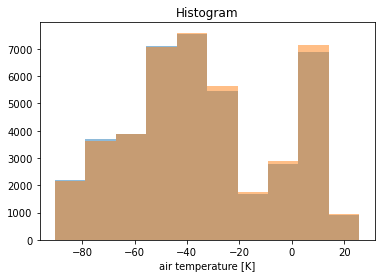

In [98]:
(ds_all['tempair_meanlev_incld'].isel(lat=0,lon=0)-273.15).plot.hist(alpha=.5)
(ds_all['tempair_meanlev_incld2'].isel(lat=0,lon=0)-273.15).plot.hist(alpha=.5)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


(array([2432., 4830., 4358., 6137., 6692., 4013., 2107., 3609., 7460.,
         980.]),
 array([-90.3582   , -78.74902  , -67.13985  , -55.530674 , -43.9215   ,
        -32.312325 , -20.70315  ,  -9.093974 ,   2.5152009,  14.124376 ,
         25.733551 ], dtype=float32),
 <BarContainer object of 10 artists>)

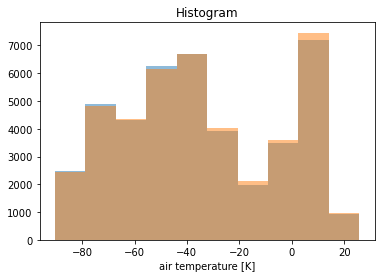

In [95]:
(ds_all['tempair_medianlev_incld'].isel(lat=0,lon=0)-273.15).plot.hist(alpha=.5)
(ds_all['tempair_medianlev_incld2'].isel(lat=0,lon=0)-273.15).plot.hist(alpha=.5)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


(array([13699.,  9023.,  4264.,  3577.,   990.,   277.,   213.,  3592.,
         6125.,   858.]),
 array([-90.90694  , -79.24289  , -67.57884  , -55.91479  , -44.25074  ,
        -32.586693 , -20.922644 ,  -9.258595 ,   2.4054534,  14.069502 ,
         25.733551 ], dtype=float32),
 <BarContainer object of 10 artists>)

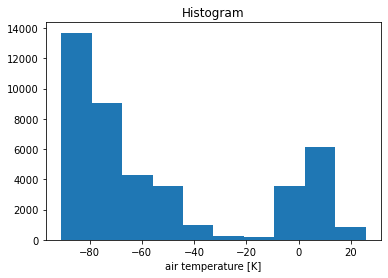

In [91]:
(ds_all['tempair_minlev_incld2'].isel(lat=0,lon=0)-273.15).plot.hist()

In [76]:
ds_all.isel(lat=0,lon=0)

<xarray.Dataset>
Dimensions:        (time: 61368, lev: 47, nhyi: 48, nhym: 47)
Coordinates:
    lat            float64 -2.798
  * lev            (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0
    lon            float64 294.4
  * time           (time) float64 730.0 730.1 730.1 ... 3.287e+03 3.287e+03
Dimensions without coordinates: nhyi, nhym
Data variables: (12/36)
    ORG_mass       (time, lev) float32 dask.array<chunksize=(61368, 47), meta=np.ndarray>
    hyai           (nhyi) float64 dask.array<chunksize=(48,), meta=np.ndarray>
    hyam           (nhym) float64 dask.array<chunksize=(47,), meta=np.ndarray>
    hybi           (nhyi) float64 dask.array<chunksize=(48,), meta=np.ndarray>
    hybm           (nhym) float64 dask.array<chunksize=(47,), meta=np.ndarray>
    airdens        (time, lev) float32 dask.array<chunksize=(61368, 47), meta=np.ndarray>
    ...             ...
    up_sw_cs       (time) float32 dask.array<chunksize=(61368,), meta=np.ndarray>
    up_sw_cs_noa   (time) float32 dask.array<chunksize=(61368,), meta=np.ndarray>
    up_sw_noa      (time) float32 dask.array<chunksize=(61368,), meta=np.ndarray>
    min_cl_temp    (time) float32 dask.array<chunksize=(61368,), meta=np.ndarray>
    min_clt_temp   (time) float32 dask.array<chunksize=(61368,), meta=np.ndarray>
    diff           (time) float32 dask.array<chunksize=(61368,), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Oct  4 20:05:09 2022: ncrcat /proj/bolinc/users/x_sarbl...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [ ]:
_df = ds_all.isel(lat=0,lon=0).to_dataframe()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [ ]:
import seaborn as sns
sns.histplot(x = 'diff',y='cod', data = ds_all.isel(lat=0,lon=0).to_dataframe())

In [ ]:
(ds_all['min_clt_temp']-273.15).where((ds_all['min_cl_temp']-273.15)>-80).isel(lat=0,lon=0).plot.hist()

In [ ]:
(ds_all['min_cl_temp']-273.15).where((ds_all['min_cl_temp']-273.15)>-80).isel(lat=0,lon=0).plot.hist()

In [ ]:
fi, ax = plt.subplots()
num_days = 5
(ds_all['tempair'].isel(lat=0,lon=0)-273.15).isel(time=slice(0,24*num_days)).plot(x='time', ylim=[47,0])

ds_all['cod'].isel(lat=0,lon=0).isel(time=slice(0,24*num_days)).plot(ax=ax.twinx(), c='r')

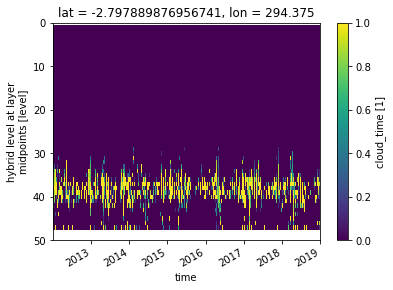

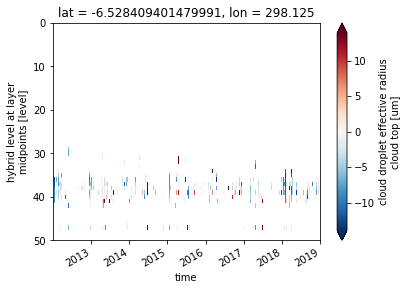

No handles with labels found to put in legend.


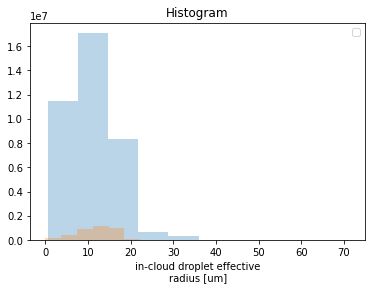

computing tempair_incld
N50
N100
N200
ORG_mass_conc
cwp
cwp_incld
hey
[######                                  ] | 16% Completed | 10.1s

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[############                            ] | 31% Completed | 38.3s

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


[########################################] | 100% Completed |  1min 48.2s


In [58]:
if True:#not fn_final_echam.exists():
    ds_all = xr.open_mfdataset(fl_open, decode_cf = False)
    #ds_iso = xr.open_dataset(fl_open[21])
    #ds = xr.merge([ds_iso,ds])
    ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)




    #ds_all = import_fields_xr_echam.decode_cf_echam(ds_all)
    ds_all = extract_2D_cloud_time_echam(ds_all)

    #ds_sel = ds_all.sel(lat = lat_smr, lon= lon_smr, method='nearest').isel( lev=model_lev_i)#.load()
    ds_all = ds_all.squeeze()
    ds_all=ds_all.drop(['hyai','hybi','hyam','hybm']).squeeze()
    ds_all = ds_all.isel( lev=model_lev_i)
    


    #ds_all = broadcase_station_data(ds_all, varl_st=varl_st_echam, lon = lon_smr, lat = lat_smr)
    

    ds_all = change_units_and_compute_vars_echam(ds_all)

    delayed_obj = ds_all.to_netcdf(fn_final_echam, compute=False)
    print('hey')
    with ProgressBar():
        results = delayed_obj.compute()

### Use station data computed before:

In [59]:
df_comb_station = dic_df_station['ECHAM-SALSA']['SALSA_BSOA_feedback']

#### Compute Nx-500

In [60]:

for v in ['N50','N100','N200','N150','N25','N70','N250']:
    if v in df_comb_station.columns:
        df_comb_station[v+'-500'] = df_comb_station[v] - df_comb_station['N500']
        varl_st_computed.append(v+'-500')
        print(v)

N50
N100
N200
N250


In [61]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=['ATTO'])

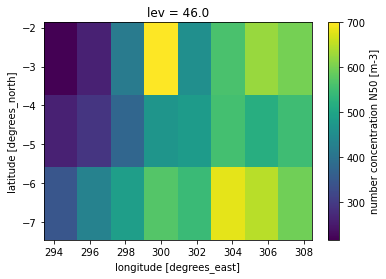

In [62]:
ds_all = xr.open_dataset(fn_final_echam,engine='netcdf4')
ds_all['time'].attrs['timezone'] = 'utc'
ds_all['N50'].mean('time').plot()#.isel(lat=0, time=0).plot()#.shape#.plot()

In [63]:
ds_all['time'].attrs['timezone'] = 'utc'

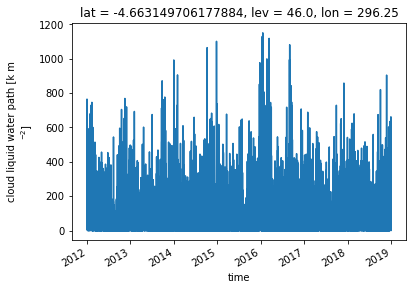

In [64]:
ds_all['cwp_incld'].isel(lat=1, lon=1).plot()

In [65]:
ds_all['tempair_ct']

<xarray.DataArray 'tempair_ct' (time: 61368, lat: 3, lon: 8)>
[1472832 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -2.798 -4.663 -6.528
    lev      float64 ...
  * lon      (lon) float64 294.4 296.2 298.1 300.0 301.9 303.8 305.6 307.5
  * time     (time) datetime64[ns] 2012-01-01T00:52:30 ... 2018-12-31T23:52:30
Attributes:
    long_name:    air temperature
    units:        K
    description:  air_temperature

### Fix time for echam

In [66]:
with xr.set_options(keep_attrs=True):
    attrs = ds_all['time'].attrs.copy()
    ds_all['time'] = ds_all['time'].to_dataframe()['time'].apply(fix_echam_time).values
    ds_all['time'].attrs = attrs

In [67]:
ds_all['time']

<xarray.DataArray 'time' (time: 61368)>
array(['2012-01-01T00:00:00.000000000', '2012-01-01T01:00:00.000000000',
       '2012-01-01T02:00:00.000000000', ..., '2018-12-31T21:00:00.000000000',
       '2018-12-31T22:00:00.000000000', '2018-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    lev      float64 46.0
  * time     (time) datetime64[ns] 2012-01-01 ... 2018-12-31T23:00:00
Attributes:
    standard_name:  time
    axis:           T
    timezone:       utc

## TESTING STUFF: 

### Check how many days we loose for masking for cloud top temperature

In [76]:
ds_all

<xarray.Dataset>
Dimensions:           (time: 61368, lat: 3, lon: 8)
Coordinates:
  * lat               (lat) float64 -2.798 -4.663 -6.528
    lev               float64 46.0
  * lon               (lon) float64 294.4 296.2 298.1 ... 303.8 305.6 307.5
  * time              (time) datetime64[ns] 2012-01-01 ... 2018-12-31T23:00:00
Data variables: (12/49)
    ORG_mass          (time, lat, lon) float32 ...
    airdens           (time, lat, lon) float32 ...
    aot550nm          (time, lat, lon) float32 ...
    ccn02             (time, lat, lon) float32 ...
    ccn10             (time, lat, lon) float32 ...
    ceff              (time, lat, lon) float32 ...
    ...                ...
    N200              (time, lat, lon) float32 ...
    OA                (time, lat, lon) float32 ...
    cwp               (time, lat, lon) float32 ...
    cwp_incld         (time, lat, lon) float32 ...
    lcdnc_cm3         (time, lat, lon) float32 ...
    T_C               (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Oct  4 20:05:09 2022: ncrcat /proj/bolinc/users/x_sarbl...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [75]:
_d = ds_all.resample(time='d').mean()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return 

In [96]:
_d['month'] = _d['time.month']
_dm = _d.where(_d['month'].isin([1,2,3]), drop=True)

In [97]:
_dm['cod'].isel(lat=0,lon=0).count()

<xarray.DataArray 'cod' ()>
array(632)
Coordinates:
    lat      float64 -2.798
    lev      float64 46.0
    lon      float64 294.4
Attributes:
    long_name:    cloud optical thickness
    units:        1
    description:  cloud optical thickness

So starting point is 632 points in each grid cell

In [100]:
_dm

<xarray.Dataset>
Dimensions:           (time: 632, lat: 3, lon: 8)
Coordinates:
  * time              (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2018-03-31
  * lat               (lat) float64 -2.798 -4.663 -6.528
    lev               float64 46.0
  * lon               (lon) float64 294.4 296.2 298.1 ... 303.8 305.6 307.5
Data variables: (12/50)
    ORG_mass          (time, lat, lon) float32 1.622e-09 1.477e-09 ... 8.025e-10
    airdens           (time, lat, lon) float32 1.111 1.13 1.151 ... 1.111 1.106
    aot550nm          (time, lat, lon) float32 0.1389 0.1224 ... 0.05178 0.06861
    ccn02             (time, lat, lon) float32 5.122e+07 4.996e+07 ... 5.372e+07
    ccn10             (time, lat, lon) float32 7.723e+07 7.313e+07 ... 9.625e+07
    ceff              (time, lat, lon) float32 0.0 0.0 ... 1.712e-06 6.517e-07
    ...                ...
    OA                (time, lat, lon) float32 2.069 1.883 1.191 ... 1.286 1.023
    cwp               (time, lat, lon) float32 128.2 101.9 55.31 ... 105.1 116.9
    cwp_incld         (time, lat, lon) float32 129.5 102.0 55.32 ... inf 118.9
    lcdnc_cm3         (time, lat, lon) float32 8.74e-35 5.492e-35 ... 6.842
    T_C               (time, lat, lon) float32 25.04 25.68 27.02 ... 24.39 24.04
    month             (time) float64 1.0 1.0 1.0 1.0 1.0 ... 3.0 3.0 3.0 3.0 3.0
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Oct  4 20:05:09 2022: ncrcat /proj/bolinc/users/x_sarbl...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [104]:
_dm.where(_dm['min_cl_tempair']>-15+273.15)['cod'].isel(lat=0,lon=0).count()

<xarray.DataArray 'cod' ()>
array(37)
Coordinates:
    lat      float64 -2.798
    lev      float64 46.0
    lon      float64 294.4
Attributes:
    long_name:    cloud optical thickness
    units:        1
    description:  cloud optical thickness

In [ ]:
_

So using cloud top temperature reduces the number of points by a factor of 10

## Any other way of checking? 

### Finally produce daily median dataset:

In [77]:
dic_ds = dict()
dic_ds[case_name] =ds_all

In [78]:
import numpy as np

(array([5.64041e+05, 2.57119e+05, 1.49413e+05, 8.69250e+04, 4.84780e+04,
        2.80940e+04, 1.71860e+04, 1.03990e+04, 6.27000e+03, 3.98900e+03,
        2.55600e+03, 1.73100e+03, 1.17100e+03, 8.24000e+02, 5.63000e+02,
        4.09000e+02, 2.56000e+02, 1.91000e+02, 1.32000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

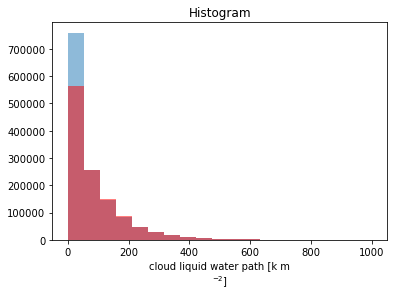

In [79]:
ds_all['cwp'].plot(bins=np.linspace(0,1000,20),alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')

In [80]:
ds_all['cwp_incld2'] = ds_all['cwp']/ds_all['cl_clfr_max']

(array([4.41623e+05, 2.89100e+05, 1.77684e+05, 1.08676e+05, 6.30710e+04,
        3.74030e+04, 2.33870e+04, 1.46190e+04, 8.95900e+03, 5.77600e+03,
        3.80000e+03, 2.51200e+03, 1.70100e+03, 1.21800e+03, 8.34000e+02,
        5.80000e+02, 4.00000e+02, 2.71000e+02, 2.05000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

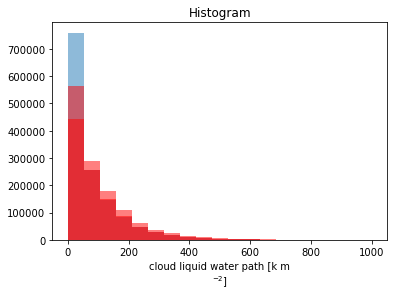

In [81]:
ds_all['cwp'].plot(bins=np.linspace(0,1000,20),alpha=.5, )

ds_all['cwp_incld'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')

ds_all['cwp_incld2'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')

(array([3.26195e+05, 1.81004e+05, 1.18267e+05, 7.36300e+04, 4.28200e+04,
        2.56640e+04, 1.61350e+04, 9.93900e+03, 6.08900e+03, 3.92100e+03,
        2.51700e+03, 1.70300e+03, 1.17400e+03, 8.19000e+02, 5.69000e+02,
        4.16000e+02, 2.62000e+02, 1.89000e+02, 1.32000e+02]),
 array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
         210.52631579,  263.15789474,  315.78947368,  368.42105263,
         421.05263158,  473.68421053,  526.31578947,  578.94736842,
         631.57894737,  684.21052632,  736.84210526,  789.47368421,
         842.10526316,  894.73684211,  947.36842105, 1000.        ]),
 <BarContainer object of 19 artists>)

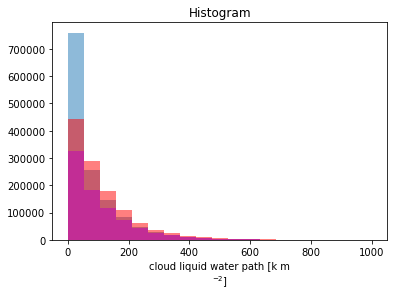

In [82]:
ds_all['cwp'].plot(bins=np.linspace(0,1000,20),alpha=.5, )

ds_all['cwp_incld2'].plot(bins=np.linspace(0,1000,20), alpha=.5, color='r')
ds_all['cwp_incld2'].where(ds_all['cl_clfr_max']>0.8).plot(bins=np.linspace(0,1000,20), alpha=.5, color='m')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecate

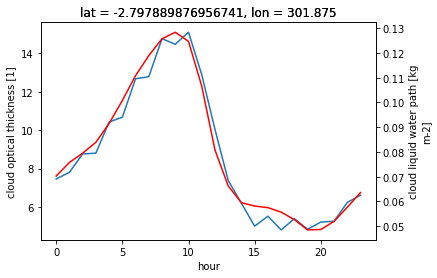

In [98]:
fig, ax = plt.subplots()
ds_all['hour'] = ds_all['time.hour']
ds_all['cod'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_all['cwp'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot(ax = ax.twinx(), c='r')
#ds_all['cod_incld'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot(marker='*')

KeyError: 'T_C'

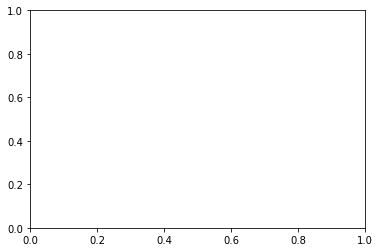

In [99]:
fig, ax = plt.subplots()
ds_all['hour'] = ds_all['time.hour']
#ds_all['T_C'].mean('time').plot()
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot(ax = ax.twinx(), c='r')
#ds_all['cod_incld'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot(marker='*')

In [ ]:
ds_['co

KeyError: 'cod_incld'

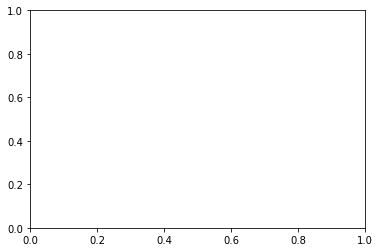

In [100]:
fig, ax = plt.subplots()
ds_all['hour'] = ds_all['time.hour']
ds_all['cod_incld'].mean('time').plot()
#ds_all['cwp'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot(ax = ax.twinx(), c='r')
#ds_all['cod_incld'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot(marker='*')

In [101]:
ds_all.where(ds_all['cwp_incld']>50).plot.scatter(x='cwp', y='cod', alpha=0.01)
plt.ylim([0,400])

KeyError: 'cwp_incld'

In [ ]:
ds_all.where(ds_all['cwp_incld']>50).plot.scatter(x='cwp_incld', y='cod_incld', alpha=0.01)
plt.ylim([0,400])

In [ ]:
ds_all.where(ds_all['cl_clfr_max']>.5).plot.scatter(x='ceff_ct', y='cod', alpha=0.01)
plt.ylim([0,400])

In [ ]:
ds_all.where(ds_all['cl_clfr_max']>.9)['cod'].plot.hist(bins=np.arange(-1,50)  )

In [ ]:
ds_all.where((ds_all['cl_time_max']>.2)&(ds_all['cwp']>50))['cod'].plot.hist(bins=np.arange(-1,50)  )

In [ ]:
ds_all.where((ds_all['cl_time_max']>.2)&(ds_all['cwp']>50))['cod'].plot.hist(bins=np.arange(-1,50)  )

In [ ]:
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_ct']>.5))['cod'].plot.hist(bins=np.arange(-1,50),  alpha=.5)

ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_max']>.5))['cod'].plot.hist(bins=np.arange(-1,50)  , alpha=.5)

In [ ]:
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_ct']>.1))['cod'].plot.hist(bins=np.arange(-1,50),  alpha=.5)


ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_max']>.1))['cod'].plot.hist(bins=np.arange(-1,50)  , alpha=.5)

In [ ]:
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_ct']>.1))['cod_incld'].plot.hist(bins=np.arange(-1,50),  alpha=.5)
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_ct']>.1))['cod'].plot.hist(bins=np.arange(-1,50),  alpha=.5)

In [ ]:
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_max']>.1))['cod_incld'].plot.hist(bins=np.arange(-1,50)  , alpha=.5)
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_max']>.1))['cod'].plot.hist(bins=np.arange(-1,50)  , alpha=.5)

In [ ]:
ds_all.where(ds_all['cwp_incld']>50).plot.scatter(x='cwp_incld', y='cod_incld', hue = 'ceff_ct', alpha=0.01)
plt.ylim([0,400])

In [ ]:
ds_all.plot.scatter(x='cwp_incld', y='cod_incld', alpha=0.5)

In [ ]:
ds_all.plot.scatter(x='cwp_incld', y='cod_incld', alpha=0.5)

In [ ]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)


ds_noresm['TGCLDCWP'].plot.hist(bins=np.logspace(0,3.1),alpha=0.5,ax = ax.twinx(), color='r')
plt.xscale('log')

In [ ]:
(ds_all['tempair_ct']-273.15).plot.hist(bins=100)

In [ ]:
(ds_all['T'].max('time')-273.15).plot()

In [ ]:
lat_smr

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


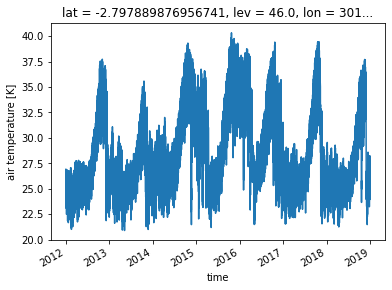

In [108]:
(ds_all['T'].sel(lat = lat_smr, lon = lon_smr, method='nearest')-273.15).plot()

In [109]:
ts = (ds_all['T'].sel(lat = lat_smr, lon = lon_smr, method='nearest')-273.15)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


In [110]:
tsn = (ds_noresm['T'].sel(lat = lat_smr, lon = lon_smr, method='nearest')-273.15)

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


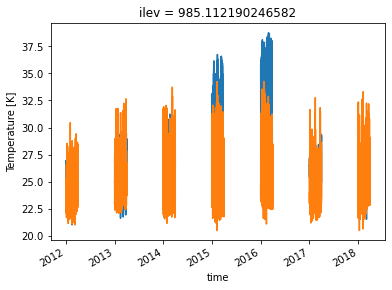

In [111]:
ts.where(ts['time.month'].isin([1,2,3])).plot()
tsn.where(ts['time.month'].isin([1,2,3])).plot()

In [112]:
tsds = ts.to_dataset()
tsds['hour'] = tsds['time.hour']
tsdsnor =tsn.to_dataset()
tsdsnor['hour'] = tsdsnor['time.hour']

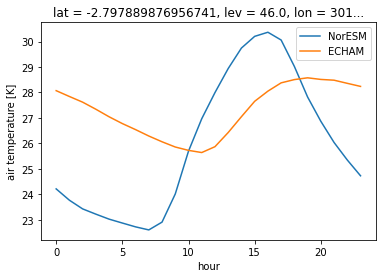

In [113]:

tsdsnor.groupby(tsdsnor['hour']).median()['T'].plot(label='NorESM')
tsds.groupby(tsds['hour']).median()['T'].plot(label='ECHAM')

plt.legend()

In [114]:
ts['time'] = pd.to_datetime(ts['time'])

In [115]:
tsn['time'] = pd.to_datetime(tsn['time'])

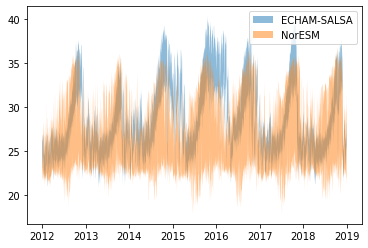

In [117]:
#ts.plot(alpha=.5)
#tsn.resample(time='1d').max().plot(alpha=0.5, label='NorESM', c='b')
ma = ts.resample(time='1d').max()#.plot(alpha=0.5, label='ECHAM-SALSA', c='r')
mi = ts.resample(time='1d').min()#.plot(alpha=0.5, label='ECHAM-SALSA', c='r')
plt.fill_between(ma['time'].values, mi, ma,alpha=0.5, label='ECHAM-SALSA')
ma = tsn.resample(time='1d').max()#.plot(alpha=0.5, label='ECHAM-SALSA', c='r')
mi = tsn.resample(time='1d').min()#.plot(alpha=0.5, label='ECHAM-SALSA', c='r')
plt.fill_between(ma['time'].values, mi, ma, alpha=0.5, label='NorESM')

#ts.plot(alpha=.5)
#tsn.resample(time='1d').min().plot(alpha=0.5, label='NorESM', c='b')
#ts.resample(time='1d').min().plot(alpha=0.5, label='ECHAM-SALSA', c='r')
plt.legend()

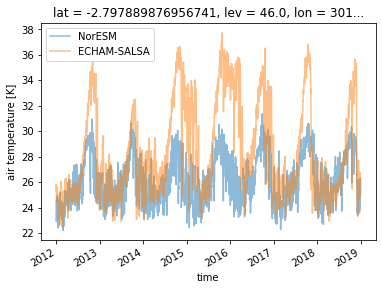

In [118]:
#ts.plot(alpha=.5)
tsn.resample(time='1d').mean().plot(alpha=0.5, label='NorESM')
ts.resample(time='1d').mean().plot(alpha=0.5, label='ECHAM-SALSA')
plt.legend()

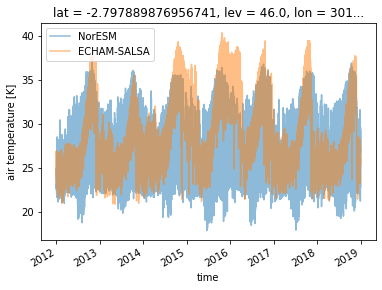

In [119]:
#ts.plot(alpha=.5)
tsn.plot(alpha=0.5, label='NorESM')
ts.plot(alpha=0.5, label='ECHAM-SALSA')
plt.legend()

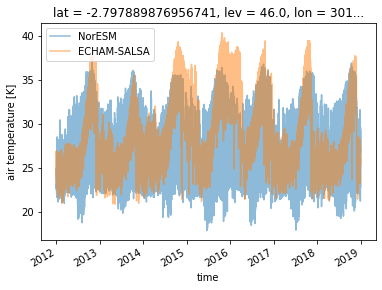

In [120]:
#ts.plot(alpha=.5)
tsn.plot(alpha=0.5, label='NorESM')
ts.plot(alpha=0.5, label='ECHAM-SALSA')
plt.legend()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecate

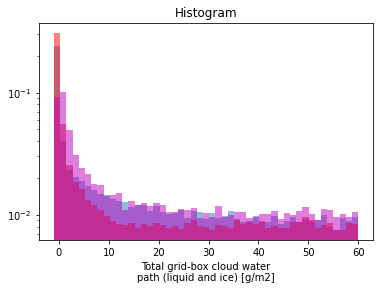

In [121]:
f, ax = plt.subplots(1)
ds_all['cwp'].sel(lat=-2,lon=290, method='nearest').plot.hist(bins=np.linspace(-1,60), alpha=.5,ax = ax,density=True)
plt.yscale('log')

ds_noresm['TGCLDCWP'].sel(lat=-2,lon=290, method='nearest').plot.hist(bins=np.linspace(-1,60),alpha=0.5,ax = ax, color='r',density=True)
ds_noresm['TGCLDCWP_incld'].sel(lat=-2,lon=290, method='nearest').plot.hist(bins=np.linspace(-1,60),alpha=0.5,ax = ax, color='m',density=True)
plt.yscale('log')

(array([ 3971.,  4354.,  4583.,  5029.,  5570.,  6060.,  6769.,  7362.,
         7912.,  8854.,  9790., 11199., 12267., 13444., 14884., 16678.,
        18533., 20113., 22241., 24524., 26970., 29554., 32722., 35633.,
        39228., 42320., 45561., 48886., 52411., 54853., 56032., 56727.,
        55760., 53818., 50145., 45799., 38993., 31434., 24875., 18885.,
        13950.,  9238.,  5909.,  3651.,  2188.,  1272.,   632.,   313.,
          103.]),
 array([1.00000000e+00, 1.15681872e+00, 1.33822954e+00, 1.54808898e+00,
        1.79085830e+00, 2.07169840e+00, 2.39657948e+00, 2.77240800e+00,
        3.20717346e+00, 3.71011828e+00, 4.29193426e+00, 4.96498988e+00,
        5.74359321e+00, 6.64429612e+00, 7.68624610e+00, 8.89159334e+00,
        1.02859616e+01, 1.18989929e+01, 1.37649776e+01, 1.59235837e+01,
        1.84206997e+01, 2.13094102e+01, 2.46511245e+01, 2.85168821e+01,
        3.29888630e+01, 3.81621341e+01, 4.41466709e+01, 5.10696951e+01,
        5.90783791e+01, 6.83429746e+01, 7.9060

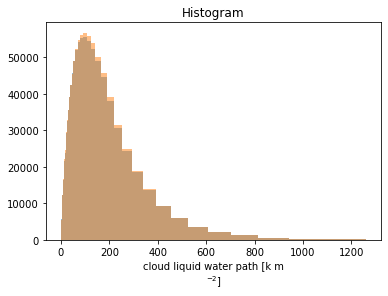

In [122]:
f, ax = plt.subplots(1)
ds_all['cwp'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)

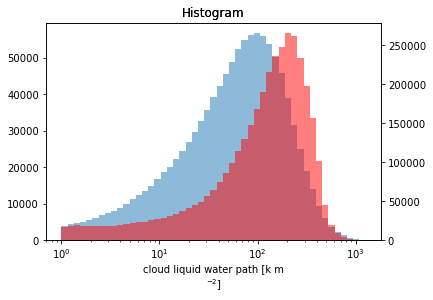

In [123]:
f, ax = plt.subplots(1)
ds_all['cwp_incld'].plot.hist(bins=np.logspace(0,3.1), alpha=.5,ax = ax)


ds_noresm['TGCLDCWP_incld'].plot.hist(bins=np.logspace(0,3.1),alpha=0.5,ax = ax.twinx(), color='r')
plt.xscale('log')

## Mask values where cloud time max is less than 10 percent

In [124]:
ds_all = ds_all.where(ds_all['cl_time_max']>.1)

In [125]:
from datetime import timedelta

## Shift timezone

In [126]:
from datetime import timedelta
with ProgressBar():
    ds_all.load()
    
    
if ds_all['time'].attrs['timezone']=='utc':
    ds_all['time'] = ds_all['time'].to_pandas().index - timedelta(hours=4)
    ds_all['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

shifted time by -4


## Broadcast computed variables so that only station value is in the gridcells. 

In [127]:
ds_smll = ds_all[['mmrtrN100']]

In [128]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station = ds_comb_station.assign_coords(station=['SMR'])

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


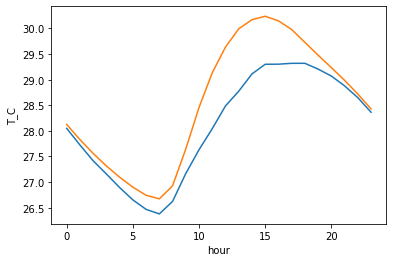

In [129]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [130]:
#ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [131]:
lat_smr

-2.15

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


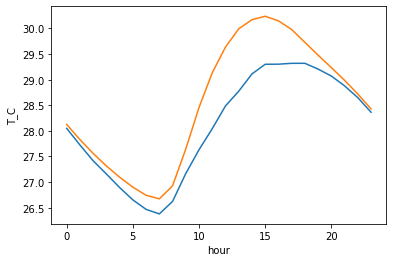

In [132]:
ds_all['hour'] = ds_all['time.hour']
ds_all['T_C'].groupby(ds_all['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot()

In [133]:
ds_comb_station = ds_comb_station.drop(['lon'])

In [134]:
varl_tmp = varl_st_echam + varl_st_computed 

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_tmp)))

In [135]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

LIMON_gas
mmrtrN250
N50-500
N100-500
VBS0_gas
oh_con
mmrtrN200
N250-500
mmrtrN500
mmrtrN3
BPIN_gas
ccn10
ORG_mass
ccn02
N200-500
SO2_gas
MYRC_gas
CARENE3_gas
VBS10_gas
OA
SABIN_gas
ISOP_gas
mmrtrN50
TBETAOCI_gas
APIN_gas
mmrtrN100
T_C


## Replace all values by station values

In [136]:
for v in varl_tmp:
    ds_all[v] = ds_smll[v]

(array([    0., 19533., 10488., 13796., 20663., 30623., 35036., 35380.,
        34558., 33374., 31714., 29236., 27382., 25075., 23279., 21375.,
        19748., 17907., 16473., 15216., 13588., 12516., 11362., 10228.,
         9243.,  8350.,  7656.,  6936.,  6353.,  5912.,  5454.,  5110.,
         4699.,  4362.,  4017.,  3699.,  3477.,  3199.,  3009.,  2735.,
         2613.,  2386.,  2276.,  2157.,  1970.,  1861.,  1681.,  1600.,
         1462.,  1433.]),
 array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <BarContainer object of 50 artists>)

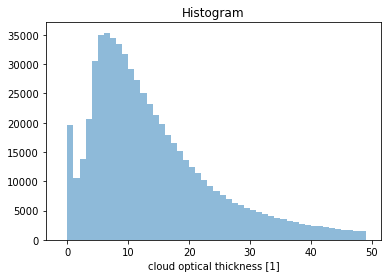

In [137]:
ds_all.where((ds_all['cwp_incld']>50)&(ds_all['cl_time_max']>.1))['cod_incld'].plot.hist(bins=np.arange(-1,50)  , alpha=.5)

## Save for different seasons: 


In [138]:
dic_ds = dict()
dic_ds[case_name_echam] =ds_all

In [139]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_echam_cloud)

In [140]:
season2month[seas]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [146]:
for seas in calc_seasons:
    _fn_csv = fn_final_echam_csv_stem.parent / (fn_final_echam_csv_stem.stem + seas+'.csv')
    print(_fn_csv)
    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, select_hours_clouds=True, summer_months=season2month[seas],mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,min_cwp =cld_water_path_above, tau_bounds = tau_lims),
                               
                               )

        df_mod = dic_df[case_name_echam]
        #with ProgressBar():
        df_mod = df_mod.dropna()    
        #df_mod.to_csv(_fn_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/ECHAM-SALSA/SALSA_BSOA_feedback/SALSA_BSOA_feedback_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 5<COT<50!
Masking with 50<CWP!
Masking with r_eff>1!
check
Masking with temp>-15 for min_cl_tempair!


<AxesSubplot:xlabel='CWP', ylabel='COT'>

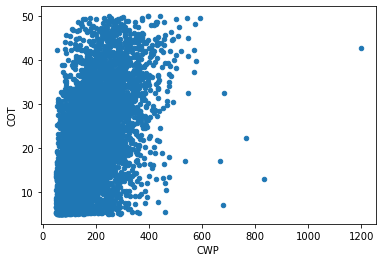

In [147]:
df_mod.plot.scatter(x='CWP', y='COT')

In [ ]:
_fn_csv

## EXTRA

In [ ]:

ds_all = xr.open_dataset(fn_comb_lev1_final)

ds_all['NCONC01'].isel(lat=1, lon=1).plot()

In [ ]:
ds_all['OA'].attrs['units'] = 'ug'

In [ ]:
ds_all.plot.scatter(x='OA',y='CLDFREE', alpha=0.1)

In [ ]:
ds_all['TOT_CLD_VISTAU_s_incld']

In [ ]:
ds_all['month'] = ds_all['time.month']

In [ ]:
ma = ((ds_all['TGCLDCWP_incld']<200 ) & (ds_all['TGCLDCWP_incld']>150 ) )& (ds_all['time.hour']<16 ) & (ds_all['time.hour']>10 ) 
ma = ma & ( (ds_all['month']>=6 ) &(ds_all['month']<=8 ))

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_m = ds_all#.where(ma)

In [ ]:
ds_m.isel(lat=0, lon = 0).groupby(ds_m['time.hour']).mean()['FLNTCDRF'].plot()

In [ ]:
ds_all.where(ma).plot.scatter(x='OA',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all['hour'] = ds_all['time.hour']
ds_all['month'] = ds_all['time.month']

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP_incld',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where((ma&(ds_all['month']==8))).plot.scatter(x='hour',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP_incld',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP',y='TOT_CLD_VISTAU_s_incld', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='TGCLDCWP',y='TOT_CLD_VISTAU_s', alpha=0.1)
plt.ylim([0,100])

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDTOT',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where((ds_all['time.hour']<15) & (ds_all['time.hour']>10) ).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where((ds_all['time.hour']<15) & (ds_all['time.hour']>10) ).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDFREE',y='TOT_CLD_VISTAU_s_incld', alpha=0.1,)

In [ ]:
ds_all.where(ma).plot.scatter(x='CLDTOT',y='CLDFREE', alpha=0.1,)

In [ ]:
ds_all['CLDFREE'].sel(lat=lat_smr, lon  = lon_smr, method = 'nearest').plot.hist()

In [ ]:
ds_all['CLDTOT'].sel(lat=lat_smr, lon  = lon_smr, method = 'nearest').plot.hist()

In [ ]:
ds_all['TGCLDCWP_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

In [ ]:
ds_all['ACTNL_incld'].where(ds_all['CLDFREE']<.99).mean('time').plot()

In [ ]:
ds_all['TGCLDCWP_incld'].mean('time').plot()

In [ ]:
ds_all['TGCLDCWP'].mean('time').plot()

In [ ]:
ds_all['TOT_CLD_VISTAU_s'].mean('time').plot()

In [ ]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ma).mean('time').plot()

In [ ]:
ds_all['TOT_CLD_VISTAU_s_incld'].where(ma).median('time').plot()